# helper functions

In [1]:
from transition_analsyis_functions import (extract_and_normalize_t1_data,add_columns_from_excel,logistic_regression_cv,create_trajectory_heatmap,print_excel_columns_all_sheets,assign_group,count_cluster_changes,get_transition_changes,assign_group,print_excel_columns_all_sheets,   )

In [2]:
import pandas as pd
import numpy as np
import os

# ----------------
# Paths
# ----------------
in_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"
excel_path = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
excel_sheet = 0

out_dir = r"only_Q_outputs/combined"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "timepoints_file_inverted_2_with_meta_and_transitions.csv")

subject_col = "Subject_Code"

# ----------------
# Binary columns (0/1) used for transitions
# ----------------
binary_cols = ["b", "t1", "t2", "t3", "after"]  # <-- edit if your column names differ

# ----------------
# Load inverted file
# ----------------
df = pd.read_csv(in_path)
if subject_col not in df.columns:
    raise ValueError(f"'{subject_col}' not found in inverted file. Columns: {list(df.columns)}")

df[subject_col] = df[subject_col].astype(str)

# ----------------
# Load Excel + choose columns to add
# ----------------
meta = pd.read_excel(excel_path, sheet_name=excel_sheet)
if subject_col not in meta.columns:
    raise ValueError(f"'{subject_col}' not found in Excel file. Columns: {list(meta.columns)}")

cols_to_add = [
    "b_PHQ_total", "T1_PHQ_total", "T2_PHQ_total", "T3_PHQ_total", "after_PHQ_total",
    "b_GAD7_total", "T1_GAD7_total", "T2_GAD7_total", "T3_GAD7_total", "after_GAD7_total",
    *binary_cols,  # include the binary columns if they are in Excel
]

# keep only columns that actually exist
cols_to_add_existing = [c for c in cols_to_add if c in meta.columns]

meta_small = meta[[subject_col] + cols_to_add_existing].copy()
meta_small[subject_col] = meta_small[subject_col].astype(str)

# ----------------
# Merge meta into the full inverted file (ONE dataframe)
# ----------------
out_df = df.merge(meta_small, on=subject_col, how="left")

# ----------------
# Helper: build a transition label column
# ----------------
def add_transition_col(df_, from_col, to_col, new_col_name):
    if from_col not in df_.columns or to_col not in df_.columns:
        raise ValueError(
            f"Missing '{from_col}' or '{to_col}' for {new_col_name}. "
            f"Available columns: {list(df_.columns)}"
        )

    a = pd.to_numeric(df_[from_col], errors="coerce")
    b = pd.to_numeric(df_[to_col], errors="coerce")

    conditions = [
        (a == 0) & (b == 0),
        (a == 0) & (b == 1),
        (a == 1) & (b == 0),
        (a == 1) & (b == 1),
    ]
    choices = ["stay_good", "worsen", "improve", "stay_bad"]

    df_[new_col_name] = np.select(conditions, choices, default="missing")
    return df_

# ----------------
# Create all transition columns
# ----------------
transitions = [
    ("b", "t1", "B_TO_T1"),
    ("t1", "t2", "T1_TO_T2"),
    ("t2", "t3", "T2_TO_T3"),
    ("t3", "after", "T3_TO_AFTER"),
]

for f, t, name in transitions:
    out_df = add_transition_col(out_df, f, t, name)

# ----------------
# Save ONE file
# ----------------
out_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Saved: only_Q_outputs/combined\timepoints_file_inverted_2_with_meta_and_transitions.csv


## find for each transistion hoe much from each transition group end up in good cluster/ clinical cluster 

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Loaded 109 subjects (ALL subjects, no filter)
Total columns: 20

Total subjects (ALL): 109
Columns: ['Subject_Code', 'b', 't1', 't2', 't3', 'after']

Creating trajectory heatmap for ALL subjects...

Transition Analysis:
b→t1: 34 changes (31.2% of subjects) <-- MOST CHANGES
t1→t2: 24 changes (22.0% of subjects)
t2→t3: 23 changes (21.1% of subjects)
t3→after: 28 changes (25.7% of subjects)


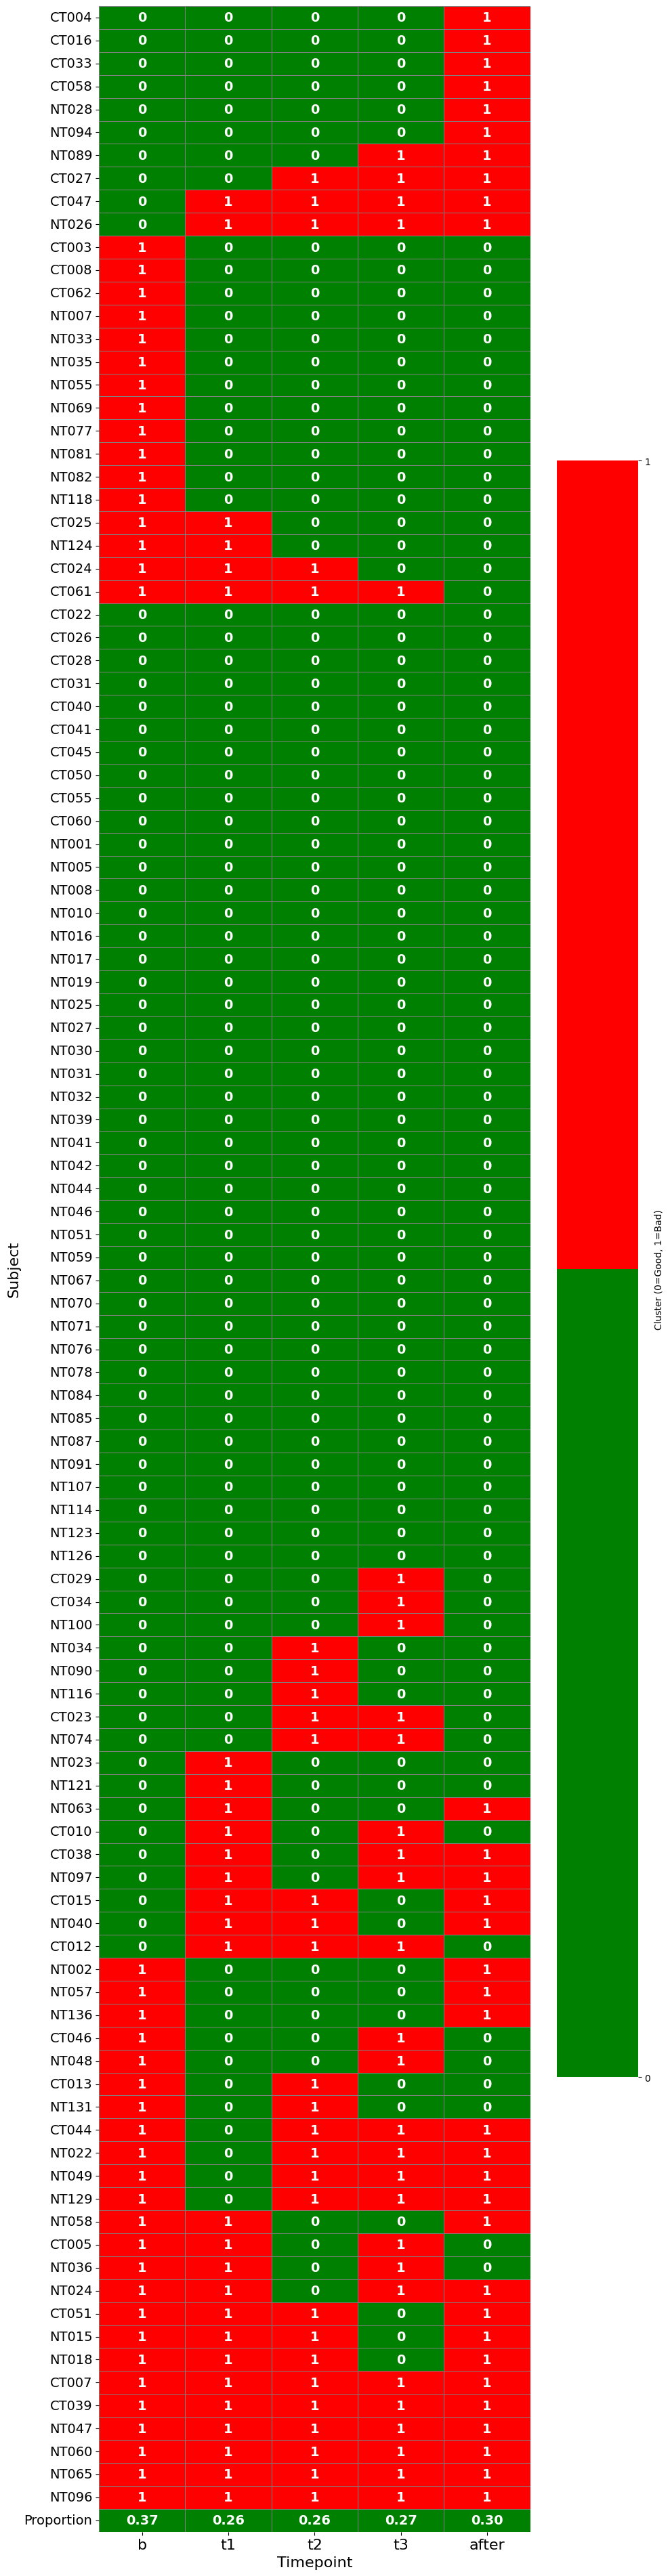


Group Distribution by Number of Cluster Changes (ALL SUBJECTS)

             Group  Count  Percentage
0 changes (stable)     48        44.0
          1 change     26        23.9
         2 changes     23        21.1
        3+ changes     12        11.0

Total subjects: 109

Example subjects from each group:

0 changes (stable) (n=48):
  CT007: 1 -> 1 -> 1 -> 1 -> 1 (changes: 0)
  CT022: 0 -> 0 -> 0 -> 0 -> 0 (changes: 0)
  CT026: 0 -> 0 -> 0 -> 0 -> 0 (changes: 0)

1 change (n=26):
  CT003: 1 -> 0 -> 0 -> 0 -> 0 (changes: 1)
  CT004: 0 -> 0 -> 0 -> 0 -> 1 (changes: 1)
  CT008: 1 -> 0 -> 0 -> 0 -> 0 (changes: 1)

2 changes (n=23):
  CT012: 0 -> 1 -> 1 -> 1 -> 0 (changes: 2)
  CT023: 0 -> 0 -> 1 -> 1 -> 0 (changes: 2)
  CT029: 0 -> 0 -> 0 -> 1 -> 0 (changes: 2)

3+ changes (n=12):
  CT005: 1 -> 1 -> 0 -> 1 -> 0 (changes: 3)
  CT010: 0 -> 1 -> 0 -> 1 -> 0 (changes: 4)
  CT013: 1 -> 0 -> 1 -> 0 -> 0 (changes: 3)


In [3]:
import pandas as pd
import os

# ----------------  
# Load ALL subjects (not just after == 1)
# ----------------
# Input file (transitions file with all timepoints)
transitions_file_path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"

# Column names
subject_col = "Subject_Code"  # Subject code column name
timepoint_cols = ["b", "t1", "t2", "t3", "after"]  # Timepoint cluster columns

# Load transitions file
print(f"Loading transitions file: {transitions_file_path}")
df_all = pd.read_csv(transitions_file_path)

print(f"Loaded {len(df_all)} subjects (ALL subjects, no filter)")
print(f"Total columns: {len(df_all.columns)}")

# Check which timepoint columns exist
existing_timepoint_cols = [col for col in timepoint_cols if col in df_all.columns]
missing_timepoint_cols = [col for col in timepoint_cols if col not in df_all.columns]

if missing_timepoint_cols:
    print(f"Warning: These timepoint columns not found: {missing_timepoint_cols}")

if not existing_timepoint_cols:
    raise ValueError(f"None of the timepoint columns {timepoint_cols} found in file.")

# Convert columns to numeric
df_all[subject_col] = df_all[subject_col].astype(str)
for col in existing_timepoint_cols:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# Select only subject code and timepoint columns (NO FILTER for after == 1)
output_df = df_all[[subject_col] + existing_timepoint_cols].copy()

# Sort by subject code
output_df = output_df.sort_values(by=subject_col).reset_index(drop=True)

print(f"\nTotal subjects (ALL): {len(output_df)}")
print(f"Columns: {list(output_df.columns)}")

# Now run the visualization code with ALL subjects
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# ----------------
# Heatmap Visualization: Trajectory of ALL subjects between clusters
# ----------------
print(f"\n{'='*70}")
print("Creating trajectory heatmap for ALL subjects...")
print(f"{'='*70}")

# Prepare data for plotting
timepoint_labels = ["b", "t1", "t2", "t3", "after"]
transition_labels = ["b→t1", "t1→t2", "t2→t3", "t3→after"]

# Create trajectory pattern string for sorting
def create_trajectory_pattern(row, timepoint_cols):
    """Create a string representation of the trajectory for sorting"""
    return '-'.join([str(int(row[col])) if not pd.isna(row[col]) else 'N' 
                     for col in timepoint_cols])

output_df['trajectory_pattern'] = output_df.apply(
    lambda row: create_trajectory_pattern(row, timepoint_labels), axis=1
)

# Count cluster changes for sorting
def count_cluster_changes(row, timepoint_cols):
    """Count the number of times cluster changes between consecutive timepoints"""
    changes = 0
    values = [row[col] for col in timepoint_cols]
    for i in range(len(values) - 1):
        if not (pd.isna(values[i]) or pd.isna(values[i+1])):
            if values[i] != values[i+1]:
                changes += 1
    return changes

output_df['n_changes'] = output_df.apply(
    lambda row: count_cluster_changes(row, timepoint_labels), axis=1
)

# Find which transition has the most changes
def get_transition_changes(row, timepoint_cols):
    """Get list of which transitions have changes (1 if change, 0 if no change)"""
    changes = []
    values = [row[col] for col in timepoint_cols]
    for i in range(len(values) - 1):
        if not (pd.isna(values[i]) or pd.isna(values[i+1])):
            changes.append(1 if values[i] != values[i+1] else 0)
        else:
            changes.append(0)
    return changes

# Add columns for each transition
for i, trans_label in enumerate(transition_labels):
    output_df[f'change_{i}'] = output_df.apply(
        lambda row: get_transition_changes(row, timepoint_labels)[i], axis=1
    )

# Calculate number of changes at each transition point
transition_counts = []
for i in range(len(transition_labels)):
    count = output_df[f'change_{i}'].sum()
    transition_counts.append(count)

# Find which transition has the most changes
max_transition_idx = np.argmax(transition_counts)
max_transition = transition_labels[max_transition_idx]
max_count = transition_counts[max_transition_idx]

print(f"\nTransition Analysis:")
print(f"{'='*70}")
for i, (trans, count) in enumerate(zip(transition_labels, transition_counts)):
    marker = " <-- MOST CHANGES" if i == max_transition_idx else ""
    print(f"{trans}: {count} changes ({count/len(output_df)*100:.1f}% of subjects){marker}")

# Sort subjects to better visualize transitions:
# 1. First by number of changes (prioritize 1 change at the top)
# 2. Then by starting cluster (b)
# 3. Then by trajectory pattern (to group similar trajectories)
# Create a custom sort key: 1 change first, then others
output_df['sort_key'] = output_df['n_changes'].apply(lambda x: 0 if x == 1 else 1)
output_df_sorted = output_df.sort_values(
    by=['sort_key', 'b', 'trajectory_pattern', 'n_changes', subject_col]
).reset_index(drop=True)

# Calculate proportions for each timepoint
proportions = []
for col in timepoint_labels:
    prop = output_df[col].mean()
    proportions.append(prop)

# Prepare data for heatmap
heatmap_data = output_df_sorted[timepoint_labels].values

# Add proportions row at the bottom
proportions_row = np.array([proportions])
heatmap_data_with_props = np.vstack([heatmap_data, proportions_row])

# Create labels (subjects + "Proportion" row)
subject_labels = list(output_df_sorted[subject_col].values) + ['Proportion']
subject_labels_array = np.array(subject_labels)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, max(10, len(output_df) * 0.35)))

# Create custom colormap: green for 0, red for 1
colors = ['green', 'red']  # 0 = green (good), 1 = red (bad)
n_bins = 2
cmap = ListedColormap(colors)

# Create annotation array - show integer values for subjects, proportions for last row
annot_data = []
for i in range(len(heatmap_data_with_props)):
    if i < len(output_df):
        # Subject rows: show integers (0 or 1)
        annot_data.append([f'{int(val)}' for val in heatmap_data_with_props[i]])
    else:
        # Proportion row: show 2 decimal places
        annot_data.append([f'{val:.2f}' for val in heatmap_data_with_props[i]])
annot_data = np.array(annot_data)

# Create heatmap
heatmap_obj = sns.heatmap(heatmap_data_with_props, 
            annot=annot_data,  # Show formatted values
            fmt='',            # Empty fmt since we're providing formatted strings
            cmap=cmap,         # Custom colormap: green=0/good, red=1/bad
            vmin=0, vmax=1,
            cbar_kws={'label': 'Cluster (0=Good, 1=Bad)', 'ticks': [0, 1]},
            yticklabels=subject_labels_array,
            xticklabels=timepoint_labels,
            linewidths=0.5,
            linecolor='gray',
            ax=ax,
            annot_kws={'size': 14, 'weight': 'bold'})  # Bigger, bold font for annotations

# Recolor the proportions row to light blue
proportions_row_idx = len(output_df)  # Index of proportions row (0-based)
quadmesh = heatmap_obj.collections[0]
face_colors = quadmesh.get_facecolors()
n_cols = len(timepoint_labels)
start_idx = proportions_row_idx * n_cols
end_idx = start_idx + n_cols
lightblue = [0.68, 0.85, 1.0, 1.0]
for idx in range(start_idx, min(end_idx, len(face_colors))):
    face_colors[idx] = lightblue
quadmesh.set_facecolors(face_colors)

ax.set_ylabel('Subject', fontsize=16)
ax.set_xlabel('Timepoint', fontsize=16)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=0, fontsize=16)

plt.tight_layout()
plt.show()

# ----------------
# Calculate and display group counts
# ----------------


output_df['n_changes'] = output_df.apply(
    lambda row: count_cluster_changes(row, timepoint_labels), axis=1
)

# Group subjects by number of changes
change_groups = {
    0: '0 changes (stable)',
    1: '1 change',
    2: '2 changes',
    3: '3+ changes'
}



output_df['change_group'] = output_df['n_changes'].apply(assign_group)

# ----------------
# Display group counts
# ----------------
print(f"\n{'='*70}")
print("Group Distribution by Number of Cluster Changes (ALL SUBJECTS)")
print(f"{'='*70}")

group_counts = output_df['change_group'].value_counts()
# Reorder to match the group order
ordered_groups = [change_groups[0], change_groups[1], change_groups[2], change_groups[3]]
group_counts_ordered = group_counts.reindex([g for g in ordered_groups if g in group_counts.index], fill_value=0)
group_percentages = (group_counts_ordered / len(output_df) * 100).round(1)

summary_df = pd.DataFrame({
    'Group': group_counts_ordered.index,
    'Count': group_counts_ordered.values,
    'Percentage': group_percentages.values
})

print("\n" + summary_df.to_string(index=False))
print(f"\nTotal subjects: {len(output_df)}")

# Show some examples from each group
print(f"\n{'='*70}")
print("Example subjects from each group:")
print(f"{'='*70}")

for group_name in ordered_groups:
    group_subjects = output_df[output_df['change_group'] == group_name]
    if len(group_subjects) > 0:
        print(f"\n{group_name} (n={len(group_subjects)}):")
        # Show first 3 subjects from this group
        examples = group_subjects.head(3)
        for idx, row in examples.iterrows():
            trajectory_str = ' -> '.join([f"{row[col]:.0f}" for col in timepoint_labels])
            print(f"  {row[subject_col]}: {trajectory_str} (changes: {row['n_changes']})")


Loading networks file: C:\Users\nogag\PycharmProjects\technion\only_Q_outputs\combined\T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 9
Columns: ['subject_code', 'after', 'DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Found 7 network columns:
  1. DMN_GM
  2. DAN_GM
  3. FPN_GM
  4. LIM_GM
  5. SMN_GM
  6. VAN_GM
  7. VIS_GM

Group Means by 'after' column:
         DMN_GM    DAN_GM    FPN_GM    LIM_GM    SMN_GM    VAN_GM    VIS_GM
after                                                                      
0.0    0.101779  0.018555  0.029672  0.041229  0.054486  0.039057  0.049079
1.0    0.102675  0.018816  0.030642  0.041409  0.056417  0.039544  0.049309


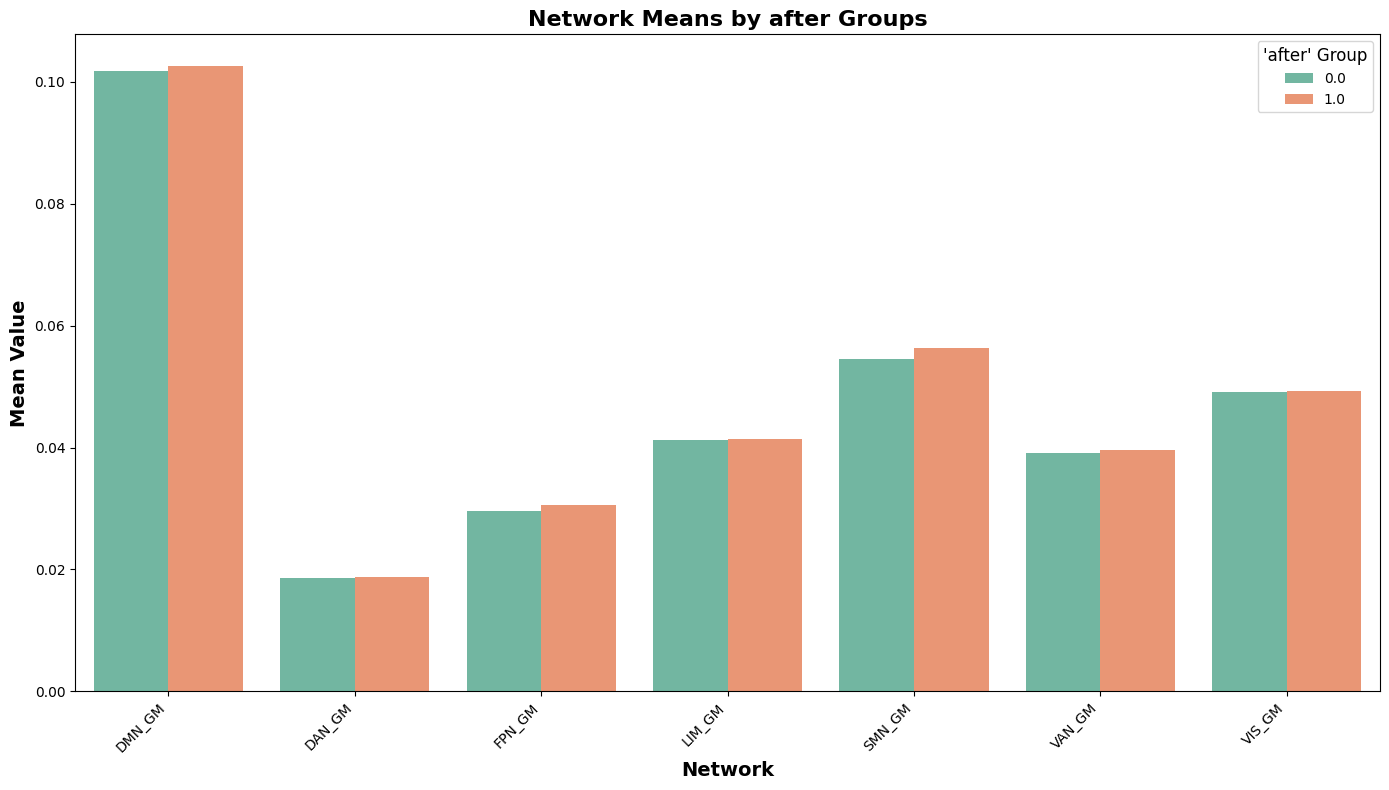


Summary Statistics:

Group after = 0.0:
  Number of subjects: 55
  Network means:
    DMN_GM: 0.1018 ± 0.0053
    DAN_GM: 0.0186 ± 0.0021
    FPN_GM: 0.0297 ± 0.0024
    LIM_GM: 0.0412 ± 0.0031
    SMN_GM: 0.0545 ± 0.0034
    VAN_GM: 0.0391 ± 0.0029
    VIS_GM: 0.0491 ± 0.0034

Group after = 1.0:
  Number of subjects: 21
  Network means:
    DMN_GM: 0.1027 ± 0.0048
    DAN_GM: 0.0188 ± 0.0013
    FPN_GM: 0.0306 ± 0.0022
    LIM_GM: 0.0414 ± 0.0019
    SMN_GM: 0.0564 ± 0.0030
    VAN_GM: 0.0395 ± 0.0025
    VIS_GM: 0.0493 ± 0.0027

Group means saved to: C:\Users\nogag\PycharmProjects\technion\only_Q_outputs\combined\T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN_group_means.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------  
# Configuration
# ----------------
# Path to your networks file (CSV format expected)
networks_file_path = r"C:\Users\nogag\PycharmProjects\technion\only_Q_outputs\combined\T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Column name for classification groups (cluster column in your networks file)
cluster_col = "after"  # Change if your cluster/classification column has a different name

# Subject identifier column name (optional, for display purposes)
subject_col = "subject_code"  # Change if your file uses a different name (e.g., "subject_code")

# ----------------  
# Load networks file (which already contains the cluster column)
# ----------------
print(f"Loading networks file: {networks_file_path}")
df = pd.read_csv(networks_file_path)

print(f"Loaded {len(df)} subjects")
print(f"Total columns: {len(df.columns)}")
print(f"Columns: {list(df.columns)}")

# Check if cluster column exists
if cluster_col not in df.columns:
    print(f"\nWarning: Column '{cluster_col}' not found in file.")
    print(f"Available columns: {list(df.columns)}")
    print(f"\nPlease update 'cluster_col' variable to match your classification column name.")
    raise ValueError(f"Cluster column '{cluster_col}' not found in file.")

# Identify network columns (all columns except subject_col and cluster_col)
exclude_cols = [cluster_col,subject_col]
if subject_col in df.columns:
    exclude_cols.append(subject_col)

network_columns = [col for col in df.columns 
                   if col not in exclude_cols]

print(f"\nFound {len(network_columns)} network columns:")
for i, net in enumerate(network_columns, 1):
    print(f"  {i}. {net}")

# ----------------  
# Calculate means by group
# ----------------
# Group by cluster column and calculate mean for each network
group_means = df.groupby(cluster_col)[network_columns].mean()

print(f"\n{'='*70}")
print(f"Group Means by '{cluster_col}' column:")
print(f"{'='*70}")
print(group_means)

# ----------------  
# Create bar graph
# ----------------
# Prepare data for plotting
# Reset index to make cluster column a regular column
group_means_plot = group_means.reset_index()

# Melt the dataframe for easier plotting
df_plot = pd.melt(
    group_means_plot, 
    id_vars=[cluster_col], 
    value_vars=network_columns,
    var_name='Network', 
    value_name='Mean'
)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Create grouped bar chart
sns.barplot(
    data=df_plot,
    x='Network',
    y='Mean',
    hue=cluster_col,
    ax=ax,
    palette='Set2'  # You can change this to 'viridis', 'tab10', etc.
)

# Customize the plot
ax.set_xlabel('Network', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Value', fontsize=14, fontweight='bold')
ax.set_title(f'Network Means by {cluster_col} Groups', fontsize=16, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(title=f"'{cluster_col}' Group", title_fontsize=12, fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# ----------------  
# Optional: Print summary statistics
# ----------------
print(f"\n{'='*70}")
print("Summary Statistics:")
print(f"{'='*70}")

for group in sorted(df[cluster_col].unique()):
    print(f"\nGroup {cluster_col} = {group}:")
    group_data = df[df[cluster_col] == group]
    print(f"  Number of subjects: {len(group_data)}")
    print(f"  Network means:")
    for net in network_columns:
        mean_val = group_data[net].mean()
        std_val = group_data[net].std()
        print(f"    {net}: {mean_val:.4f} ± {std_val:.4f}")

# Save the means to CSV if desired
output_csv = networks_file_path.replace('.csv', '_group_means.csv')
group_means.to_csv(output_csv)
print(f"\nGroup means saved to: {output_csv}")



=== B_TO_T1 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
B_TO_T1                                                       
improve           16       69.6          7       30.4       23
stay_bad           6       35.3         11       64.7       17
stay_good         50       86.2          8       13.8       58
worsen             4       36.4          7       63.6       11


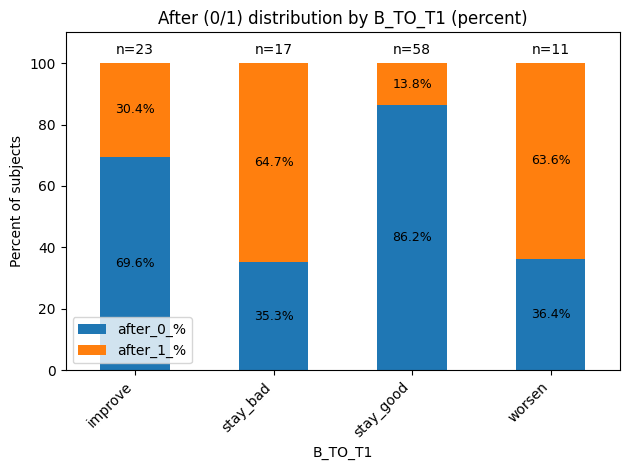


=== T1_TO_T2 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T1_TO_T2                                                      
improve            7       58.3          5       41.7       12
stay_bad           3       18.8         13       81.2       16
stay_good         59       85.5         10       14.5       69
worsen             7       58.3          5       41.7       12


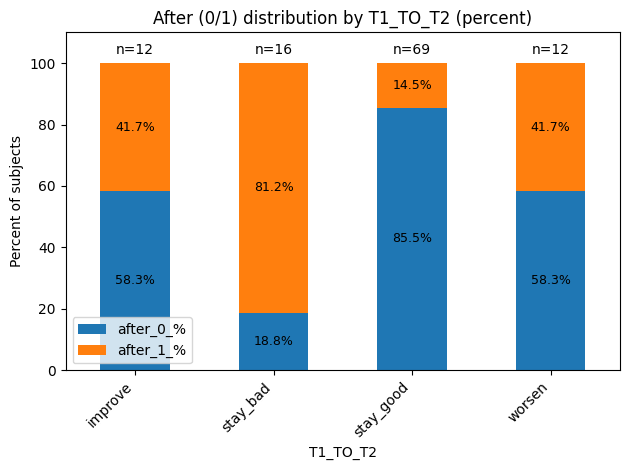


=== T2_TO_T3 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T2_TO_T3                                                      
improve            6       54.5          5       45.5       11
stay_bad           4       23.5         13       76.5       17
stay_good         58       84.1         11       15.9       69
worsen             8       66.7          4       33.3       12


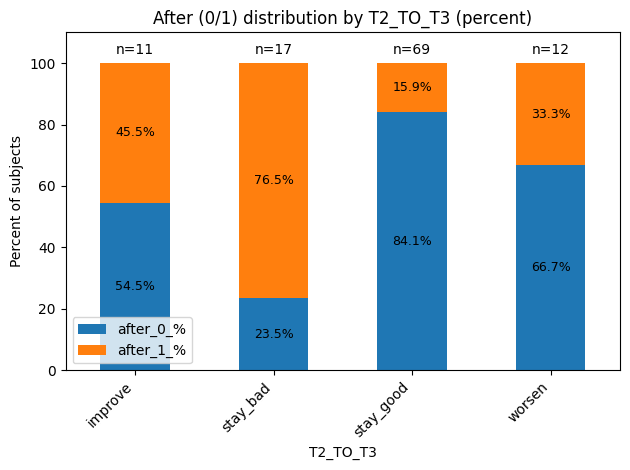


=== T3_TO_AFTER (COUNTS + PERCENT) ===
             after_0_n  after_0_%  after_1_n  after_1_%  n_total
T3_TO_AFTER                                                     
improve             12      100.0          0        0.0       12
stay_bad             0        0.0         17      100.0       17
stay_good           64      100.0          0        0.0       64
worsen               0        0.0         16      100.0       16


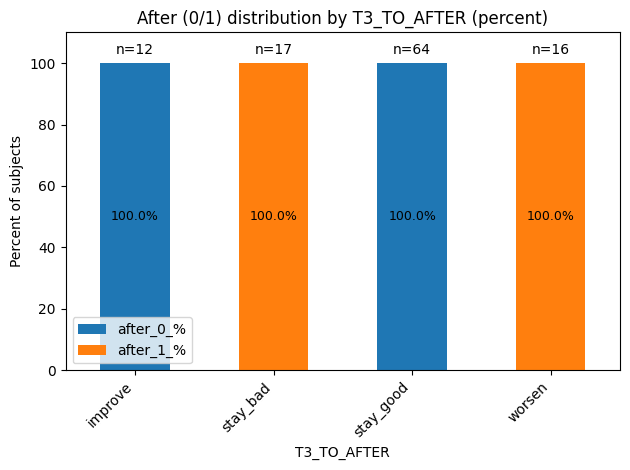

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"
df = pd.read_csv(path)

df["after"] = pd.to_numeric(df["after"], errors="coerce")
df2 = df[df["after"].isin([0, 1])].copy()

transition_cols = ["B_TO_T1", "T1_TO_T2", "T2_TO_T3", "T3_TO_AFTER"]

for col in transition_cols:
    # counts
    counts = pd.crosstab(df2[col], df2["after"]).reindex(columns=[0, 1], fill_value=0)
    counts.columns = ["after_0_n", "after_1_n"]
    counts["n_total"] = counts["after_0_n"] + counts["after_1_n"]

    # percentages
    pct = counts[["after_0_n", "after_1_n"]].div(counts["n_total"], axis=0) * 100
    pct.columns = ["after_0_%", "after_1_%"]

    # combined table
    summary = pd.concat([counts, pct], axis=1)
    summary = summary[["after_0_n", "after_0_%", "after_1_n", "after_1_%", "n_total"]]

    print(f"\n=== {col} (COUNTS + PERCENT) ===")
    print(summary.round({"after_0_%": 1, "after_1_%": 1}))

    # plot percentages
    ax = pct.plot(kind="bar", stacked=True)
    ax.set_title(f"After (0/1) distribution by {col} (percent)")
    ax.set_xlabel(col)
    ax.set_ylabel("Percent of subjects")
    plt.xticks(rotation=45, ha="right")

    # annotate percentages inside bars
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height <= 0:
                continue
            if height < 5:  # optional
                continue
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + height / 2
            ax.text(x, y, f"{height:.1f}%", ha="center", va="center", fontsize=9)

    # annotate n above each bar
    group_n = counts["n_total"]
    for i, n in enumerate(group_n.values):
        ax.text(i, 102, f"n={int(n)}", ha="center", va="bottom", fontsize=10)

    ax.set_ylim(0, 110)
    plt.tight_layout()
    plt.show()



=== B_TO_T1 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
B_TO_T1                                                       
improve           16       69.6          7       30.4       23
stay_bad           6       35.3         11       64.7       17
stay_good         50       86.2          8       13.8       58
worsen             4       36.4          7       63.6       11


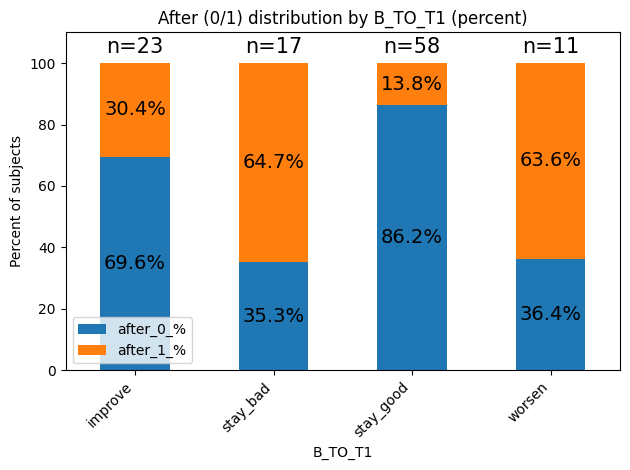


=== T1_TO_T2 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T1_TO_T2                                                      
improve            7       58.3          5       41.7       12
stay_bad           3       18.8         13       81.2       16
stay_good         59       85.5         10       14.5       69
worsen             7       58.3          5       41.7       12


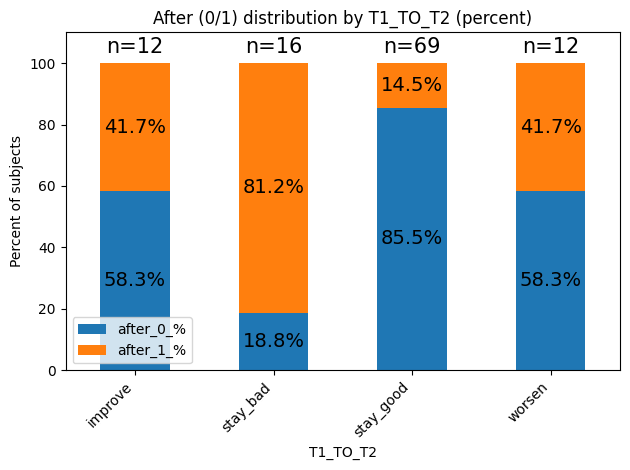


=== T2_TO_T3 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T2_TO_T3                                                      
improve            6       54.5          5       45.5       11
stay_bad           4       23.5         13       76.5       17
stay_good         58       84.1         11       15.9       69
worsen             8       66.7          4       33.3       12


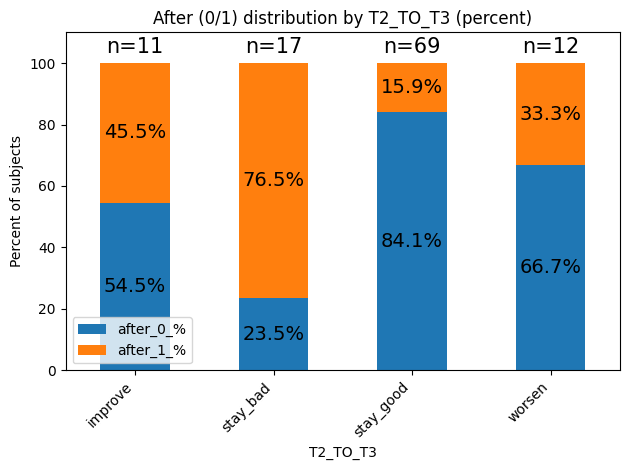


=== T3_TO_AFTER (COUNTS + PERCENT) ===
             after_0_n  after_0_%  after_1_n  after_1_%  n_total
T3_TO_AFTER                                                     
improve             12      100.0          0        0.0       12
stay_bad             0        0.0         17      100.0       17
stay_good           64      100.0          0        0.0       64
worsen               0        0.0         16      100.0       16


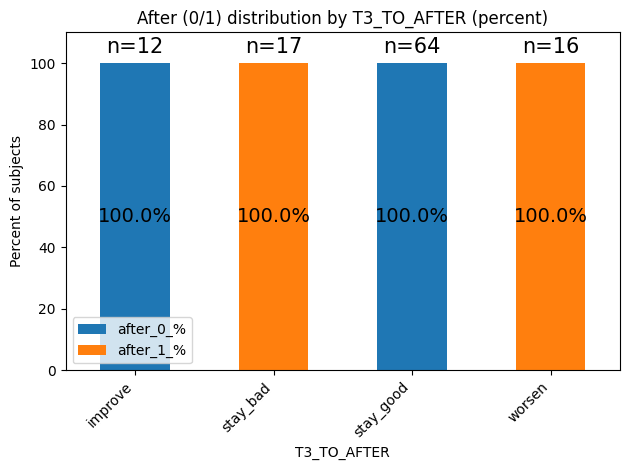


=== B_TO_T1 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
B_TO_T1                                                       
improve           16       69.6          7       30.4       23
stay_bad           6       35.3         11       64.7       17
stay_good         50       86.2          8       13.8       58
worsen             4       36.4          7       63.6       11


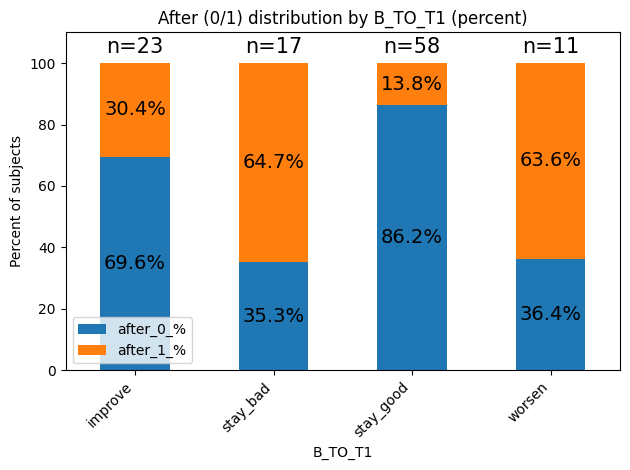


=== T1_TO_T2 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T1_TO_T2                                                      
improve            7       58.3          5       41.7       12
stay_bad           3       18.8         13       81.2       16
stay_good         59       85.5         10       14.5       69
worsen             7       58.3          5       41.7       12


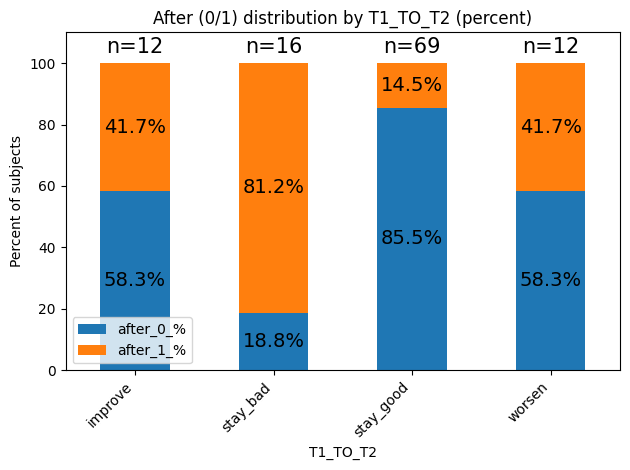


=== T2_TO_T3 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T2_TO_T3                                                      
improve            6       54.5          5       45.5       11
stay_bad           4       23.5         13       76.5       17
stay_good         58       84.1         11       15.9       69
worsen             8       66.7          4       33.3       12


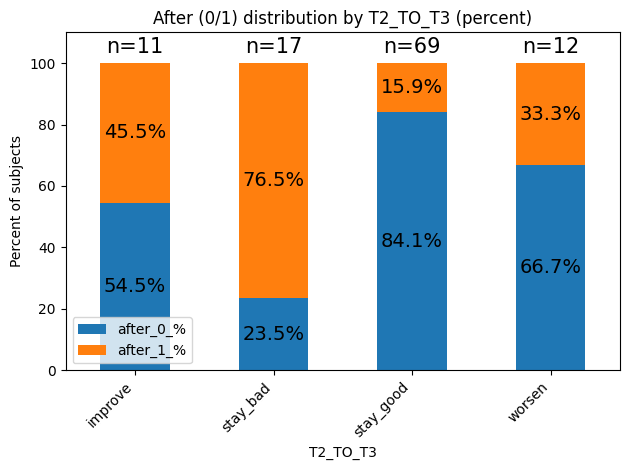


=== T3_TO_AFTER (COUNTS + PERCENT) ===
             after_0_n  after_0_%  after_1_n  after_1_%  n_total
T3_TO_AFTER                                                     
improve             12      100.0          0        0.0       12
stay_bad             0        0.0         17      100.0       17
stay_good           64      100.0          0        0.0       64
worsen               0        0.0         16      100.0       16


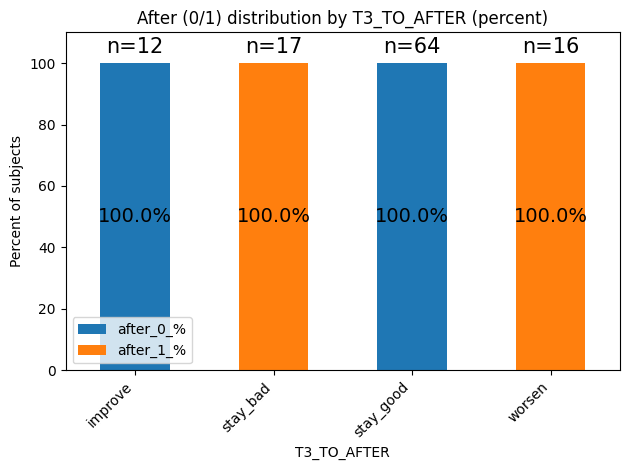


=== B_TO_T1 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
B_TO_T1                                                       
improve           16       69.6          7       30.4       23
stay_bad           6       35.3         11       64.7       17
stay_good         50       86.2          8       13.8       58
worsen             4       36.4          7       63.6       11


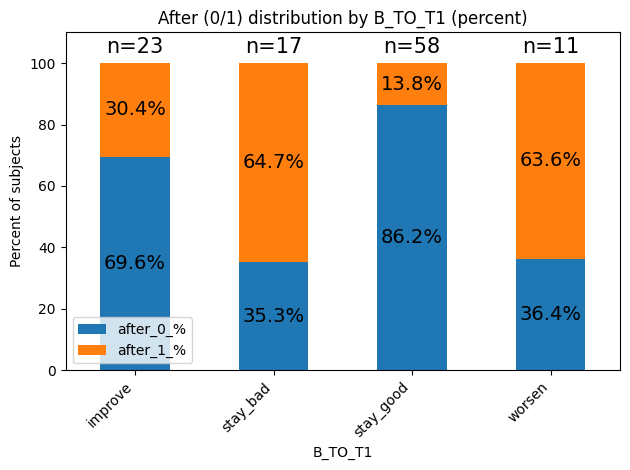


=== T1_TO_T2 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T1_TO_T2                                                      
improve            7       58.3          5       41.7       12
stay_bad           3       18.8         13       81.2       16
stay_good         59       85.5         10       14.5       69
worsen             7       58.3          5       41.7       12


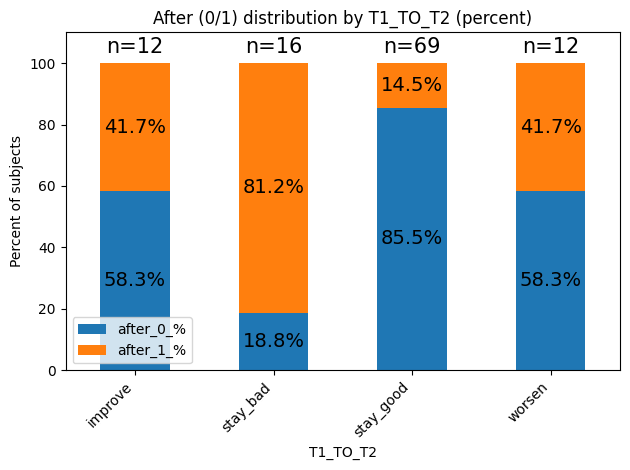


=== B_TO_T1 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
B_TO_T1                                                       
improve           16       69.6          7       30.4       23
stay_bad           6       35.3         11       64.7       17
stay_good         50       86.2          8       13.8       58
worsen             4       36.4          7       63.6       11


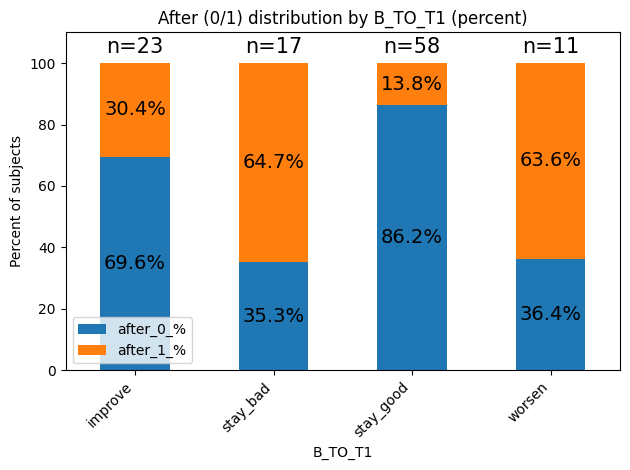


=== T1_TO_T2 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T1_TO_T2                                                      
improve            7       58.3          5       41.7       12
stay_bad           3       18.8         13       81.2       16
stay_good         59       85.5         10       14.5       69
worsen             7       58.3          5       41.7       12


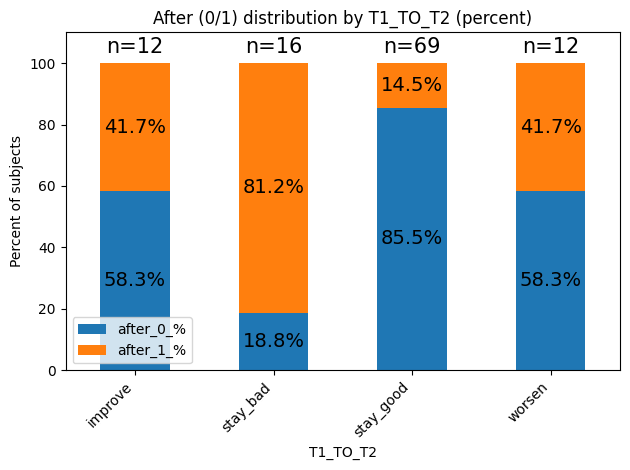


=== T2_TO_T3 (COUNTS + PERCENT) ===
           after_0_n  after_0_%  after_1_n  after_1_%  n_total
T2_TO_T3                                                      
improve            6       54.5          5       45.5       11
stay_bad           4       23.5         13       76.5       17
stay_good         58       84.1         11       15.9       69
worsen             8       66.7          4       33.3       12


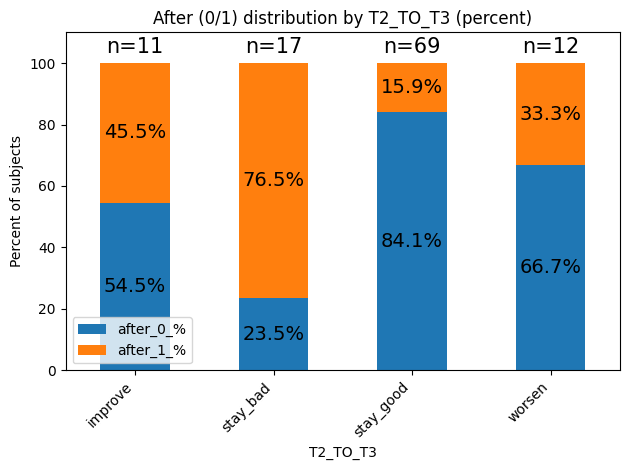


=== T3_TO_AFTER (COUNTS + PERCENT) ===
             after_0_n  after_0_%  after_1_n  after_1_%  n_total
T3_TO_AFTER                                                     
improve             12      100.0          0        0.0       12
stay_bad             0        0.0         17      100.0       17
stay_good           64      100.0          0        0.0       64
worsen               0        0.0         16      100.0       16


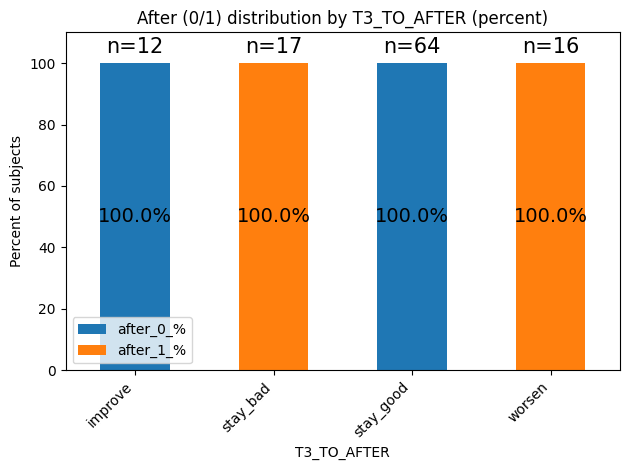

In [6]:
# Option 1: Using file path (like your original code)
from transition_analsyis_functions import analyze_transition_to_after

result_df = analyze_transition_to_after(
    file_path=r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"
)

# Option 2: Using existing DataFrame
df = pd.read_csv(r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv")
result_df = analyze_transition_to_after(df=df)

# Option 3: Custom transition columns
result_df = analyze_transition_to_after(
    file_path=r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv",
    transition_cols=["B_TO_T1", "T1_TO_T2"]  # Only analyze these
)

# Option 4: Get summary tables back
summaries = analyze_transition_to_after(
    file_path=r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv",
    return_summaries=True
)
# summaries is a dict: {"B_TO_T1": DataFrame, "T1_TO_T2": DataFrame, ...}

In [7]:
import pandas as pd
import os

# ----------------
# Configuration
# ----------------
# Input file (transitions file with all timepoints)
transitions_file_path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"

# Output file
out_dir = r"only_Q_outputs/combined"
os.makedirs(out_dir, exist_ok=True)
output_file_path = os.path.join(out_dir, "subjects_after_1_with_timepoints.csv")

# Column names
subject_col = "Subject_Code"  # Subject code column name
timepoint_cols = ["b", "t1", "t2", "t3", "after"]  # Timepoint cluster columns
after_col = "after"  # Column to filter on (should be 1)

# ----------------
# Load transitions file
# ----------------
print(f"Loading transitions file: {transitions_file_path}")
df = pd.read_csv(transitions_file_path)

print(f"Loaded {len(df)} subjects")
print(f"Total columns: {len(df.columns)}")

# ----------------
# Check required columns
# ----------------
if subject_col not in df.columns:
    raise ValueError(f"'{subject_col}' not found in file. Available columns: {list(df.columns)}")

if after_col not in df.columns:
    raise ValueError(f"'{after_col}' not found in file. Available columns: {list(df.columns)}")

# Check which timepoint columns exist
existing_timepoint_cols = [col for col in timepoint_cols if col in df.columns]
missing_timepoint_cols = [col for col in timepoint_cols if col not in df.columns]

if missing_timepoint_cols:
    print(f"Warning: These timepoint columns not found: {missing_timepoint_cols}")

if not existing_timepoint_cols:
    raise ValueError(f"None of the timepoint columns {timepoint_cols} found in file.")

# ----------------
# Convert columns to numeric
# ----------------
df[after_col] = pd.to_numeric(df[after_col], errors="coerce")
df[subject_col] = df[subject_col].astype(str)

for col in existing_timepoint_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ----------------
# Filter subjects with after = 1
# ----------------
print(f"\n{'='*70}")
print("Filtering subjects with after = 1...")
print(f"{'='*70}")

n_before = len(df)
df_filtered = df[df[after_col] == 1].copy()
n_after = len(df_filtered)

print(f"Subjects before filtering: {n_before}")
print(f"Subjects with {after_col} = 1: {n_after}")
print(f"Subjects removed: {n_before - n_after}")

# ----------------
# Select only subject code and timepoint columns
# ----------------
output_df = df_filtered[[subject_col] + existing_timepoint_cols].copy()

# Sort by subject code
output_df = output_df.sort_values(by=subject_col).reset_index(drop=True)

# ----------------
# Save output file
# ----------------
output_df.to_csv(output_file_path, index=False)

print(f"\n{'='*70}")
print(f"Output file saved: {output_file_path}")
print(f"Total subjects: {len(output_df)}")
print(f"Total columns: {len(output_df.columns)}")
print(f"Columns: {list(output_df.columns)}")
print(f"\nFirst few rows:")
print(output_df.head(15))
print(f"\nTimepoint distribution:")
for col in existing_timepoint_cols:
    if col != after_col:
        print(f"\n{col}:")
        print(output_df[col].value_counts().sort_index())

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Loaded 109 subjects
Total columns: 20

Filtering subjects with after = 1...
Subjects before filtering: 109
Subjects with after = 1: 33
Subjects removed: 76

Output file saved: only_Q_outputs/combined\subjects_after_1_with_timepoints.csv
Total subjects: 33
Total columns: 6
Columns: ['Subject_Code', 'b', 't1', 't2', 't3', 'after']

First few rows:
   Subject_Code  b  t1  t2  t3  after
0         CT004  0   0   0   0      1
1         CT007  1   1   1   1      1
2         CT015  0   1   1   0      1
3         CT016  0   0   0   0      1
4         CT027  0   0   1   1      1
5         CT033  0   0   0   0      1
6         CT038  0   1   0   1      1
7         CT039  1   1   1   1      1
8         CT044  1   0   1   1      1
9         CT047  0   1   1   1      1
10        CT051  1   1   1   0      1
11        CT058  0   0   0   0      1
12        NT002  1   0   0   0      1
13        NT0


Creating trajectory heatmap...

Transition Analysis:
b→t1: 14 changes (42.4% of subjects)
t1→t2: 10 changes (30.3% of subjects)
t2→t3: 9 changes (27.3% of subjects)
t3→after: 16 changes (48.5% of subjects) <-- MOST CHANGES


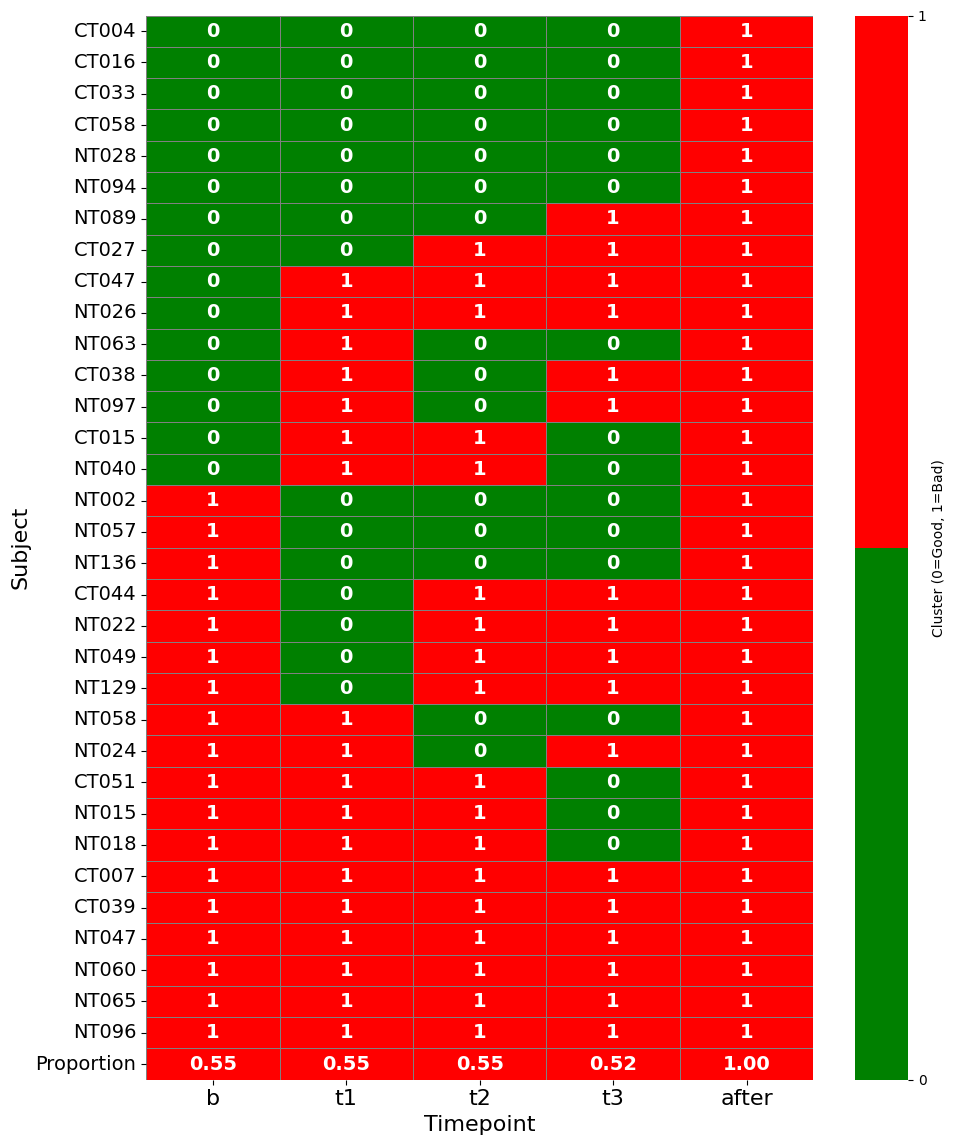


Group Distribution by Number of Cluster Changes

             Group  Count  Percentage
0 changes (stable)      6        18.2
          1 change     10        30.3
         2 changes     12        36.4
        3+ changes      5        15.2

Total subjects: 33

Example subjects from each group:

0 changes (stable) (n=6):
  CT007: 1 -> 1 -> 1 -> 1 -> 1 (changes: 0)
  CT039: 1 -> 1 -> 1 -> 1 -> 1 (changes: 0)
  NT047: 1 -> 1 -> 1 -> 1 -> 1 (changes: 0)

1 change (n=10):
  CT004: 0 -> 0 -> 0 -> 0 -> 1 (changes: 1)
  CT016: 0 -> 0 -> 0 -> 0 -> 1 (changes: 1)
  CT027: 0 -> 0 -> 1 -> 1 -> 1 (changes: 1)

2 changes (n=12):
  CT044: 1 -> 0 -> 1 -> 1 -> 1 (changes: 2)
  CT051: 1 -> 1 -> 1 -> 0 -> 1 (changes: 2)
  NT002: 1 -> 0 -> 0 -> 0 -> 1 (changes: 2)

3+ changes (n=5):
  CT015: 0 -> 1 -> 1 -> 0 -> 1 (changes: 3)
  CT038: 0 -> 1 -> 0 -> 1 -> 1 (changes: 3)
  NT040: 0 -> 1 -> 1 -> 0 -> 1 (changes: 3)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# ----------------
# Heatmap Visualization: Trajectory of subjects between clusters
# ----------------
print(f"\n{'='*70}")
print("Creating trajectory heatmap...")
print(f"{'='*70}")

# Prepare data for plotting
timepoint_labels = ["b", "t1", "t2", "t3", "after"]
transition_labels = ["b→t1", "t1→t2", "t2→t3", "t3→after"]

# Create trajectory pattern string for sorting
def create_trajectory_pattern(row, timepoint_cols):
    """Create a string representation of the trajectory for sorting"""
    return '-'.join([str(int(row[col])) if not pd.isna(row[col]) else 'N' 
                     for col in timepoint_cols])

output_df['trajectory_pattern'] = output_df.apply(
    lambda row: create_trajectory_pattern(row, timepoint_labels), axis=1
)

# Count cluster changes for sorting
def count_cluster_changes(row, timepoint_cols):
    """Count the number of times cluster changes between consecutive timepoints"""
    changes = 0
    values = [row[col] for col in timepoint_cols]
    for i in range(len(values) - 1):
        if not (pd.isna(values[i]) or pd.isna(values[i+1])):
            if values[i] != values[i+1]:
                changes += 1
    return changes

output_df['n_changes'] = output_df.apply(
    lambda row: count_cluster_changes(row, timepoint_labels), axis=1
)

# Find which transition has the most changes
def get_transition_changes(row, timepoint_cols):
    """Get list of which transitions have changes (1 if change, 0 if no change)"""
    changes = []
    values = [row[col] for col in timepoint_cols]
    for i in range(len(values) - 1):
        if not (pd.isna(values[i]) or pd.isna(values[i+1])):
            changes.append(1 if values[i] != values[i+1] else 0)
        else:
            changes.append(0)
    return changes

# Add columns for each transition
for i, trans_label in enumerate(transition_labels):
    output_df[f'change_{i}'] = output_df.apply(
        lambda row: get_transition_changes(row, timepoint_labels)[i], axis=1
    )

# Calculate number of changes at each transition point
transition_counts = []
for i in range(len(transition_labels)):
    count = output_df[f'change_{i}'].sum()
    transition_counts.append(count)

# Find which transition has the most changes
max_transition_idx = np.argmax(transition_counts)
max_transition = transition_labels[max_transition_idx]
max_count = transition_counts[max_transition_idx]

print(f"\nTransition Analysis:")
print(f"{'='*70}")
for i, (trans, count) in enumerate(zip(transition_labels, transition_counts)):
    marker = " <-- MOST CHANGES" if i == max_transition_idx else ""
    print(f"{trans}: {count} changes ({count/len(output_df)*100:.1f}% of subjects){marker}")

# Sort subjects to better visualize transitions:
# 1. First by number of changes (prioritize 1 change at the top)
# 2. Then by starting cluster (b)
# 3. Then by trajectory pattern (to group similar trajectories)
# Create a custom sort key: 1 change first, then others
output_df['sort_key'] = output_df['n_changes'].apply(lambda x: 0 if x == 1 else 1)
output_df_sorted = output_df.sort_values(
    by=['sort_key', 'b', 'trajectory_pattern', 'n_changes', subject_col]
).reset_index(drop=True)

# Calculate proportions for each timepoint
proportions = []
for col in timepoint_labels:
    prop = output_df[col].mean()
    proportions.append(prop)

# Prepare data for heatmap
heatmap_data = output_df_sorted[timepoint_labels].values

# Create transition changes row (showing number of changes between timepoints)
# This will be displayed between columns, so we need to create a row with NaN/placeholder values
# We'll add it as a separate visualization element or as a text annotation

# Add proportions row at the bottom
proportions_row = np.array([proportions])
heatmap_data_with_props = np.vstack([heatmap_data, proportions_row])

# Create labels (subjects + "Proportion" row)
subject_labels = list(output_df_sorted[subject_col].values) + ['Proportion']
subject_labels_array = np.array(subject_labels)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, max(10, len(output_df) * 0.35)))

# Create custom colormap: green for 0, red for 1
colors = ['green', 'red']  # 0 = green (good), 1 = red (bad)
n_bins = 2
cmap = ListedColormap(colors)

# Create annotation array - show integer values for subjects, proportions for last row
annot_data = []
for i in range(len(heatmap_data_with_props)):
    if i < len(output_df):
        # Subject rows: show integers (0 or 1)
        annot_data.append([f'{int(val)}' for val in heatmap_data_with_props[i]])
    else:
        # Proportion row: show 2 decimal places
        annot_data.append([f'{val:.2f}' for val in heatmap_data_with_props[i]])
annot_data = np.array(annot_data)

# Create heatmap
# Create heatmap with all data
heatmap_obj = sns.heatmap(heatmap_data_with_props, 
            annot=annot_data,  # Show formatted values
            fmt='',            # Empty fmt since we're providing formatted strings
            cmap=cmap,         # Custom colormap: green=0/good, red=1/bad
            vmin=0, vmax=1,
            cbar_kws={'label': 'Cluster (0=Good, 1=Bad)', 'ticks': [0, 1]},
            yticklabels=subject_labels_array,
            xticklabels=timepoint_labels,
            linewidths=0.5,
            linecolor='gray',
            ax=ax,
            annot_kws={'size': 14, 'weight': 'bold'})  # Bigger, bold font for annotations

# Recolor the proportions row to light blue using patches
# Recolor the proportions row to light blue
proportions_row_idx = len(output_df)  # Index of proportions row (0-based)
# Get the QuadMesh collection from the heatmap
quadmesh = heatmap_obj.collections[0]
# Get the face colors array
face_colors = quadmesh.get_facecolors()
# Calculate the number of columns
n_cols = len(timepoint_labels)
# The colors are stored in row-major order: row i starts at index i * n_cols
# Change colors for the proportions row (last row)
start_idx = proportions_row_idx * n_cols
end_idx = start_idx + n_cols
# Set light blue color (RGBA)
lightblue = [0.68, 0.85, 1.0, 1.0]
for idx in range(start_idx, min(end_idx, len(face_colors))):
    face_colors[idx] = lightblue
# Update the QuadMesh with new colors
quadmesh.set_facecolors(face_colors)



ax.set_ylabel('Subject', fontsize=16)
ax.set_xlabel('Timepoint', fontsize=16)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=0, fontsize=16)


plt.tight_layout()
plt.show()
output_df['n_changes'] = output_df.apply(
    lambda row: count_cluster_changes(row, timepoint_labels), axis=1
)

# Group subjects by number of changes
change_groups = {
    0: '0 changes (stable)',
    1: '1 change',
    2: '2 changes',
    3: '3+ changes'
}


output_df['change_group'] = output_df['n_changes'].apply(assign_group)

# ----------------
# Display group counts
# ----------------
print(f"\n{'='*70}")
print("Group Distribution by Number of Cluster Changes")
print(f"{'='*70}")

group_counts = output_df['change_group'].value_counts()
# Reorder to match the group order
ordered_groups = [change_groups[0], change_groups[1], change_groups[2], change_groups[3]]
group_counts_ordered = group_counts.reindex([g for g in ordered_groups if g in group_counts.index], fill_value=0)
group_percentages = (group_counts_ordered / len(output_df) * 100).round(1)

summary_df = pd.DataFrame({
    'Group': group_counts_ordered.index,
    'Count': group_counts_ordered.values,
    'Percentage': group_percentages.values
})

print("\n" + summary_df.to_string(index=False))
print(f"\nTotal subjects: {len(output_df)}")

# Show some examples from each group
print(f"\n{'='*70}")
print("Example subjects from each group:")
print(f"{'='*70}")

for group_name in ordered_groups:
    group_subjects = output_df[output_df['change_group'] == group_name]
    if len(group_subjects) > 0:
        print(f"\n{group_name} (n={len(group_subjects)}):")
        # Show first 3 subjects from this group
        examples = group_subjects.head(3)
        for idx, row in examples.iterrows():
            trajectory_str = ' -> '.join([f"{row[col]:.0f}" for col in timepoint_labels])
            print(f"  {row[subject_col]}: {trajectory_str} (changes: {row['n_changes']})")


In [9]:
# Load your data (as you're already doing)
transitions_file_path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"
df_all = pd.read_csv(transitions_file_path)

# Select only subject code and timepoint columns
timepoint_cols = ["b", "t1", "t2", "t3", "after"]
output_df = df_all[["Subject_Code"] + timepoint_cols].copy()

# Option 1: Include everyone
result_df = visualize_trajectory_heatmap(output_df, subject_col="Subject_Code", filter_after_one=False)

# Option 2: Only subjects with after == 1
result_df = visualize_trajectory_heatmap(output_df, subject_col="Subject_Code", filter_after_one=True)

NameError: name 'visualize_trajectory_heatmap' is not defined

In [ ]:


# Example usage:
excel_path = r"T1\stats_t1_fs\ses1\ses1_T1_data.xlsx"
all_dfs = print_excel_columns_all_sheets(excel_path)


Excel file: T1\stats_t1_fs\ses1\ses1_T1_data.xlsx
Total sheets: 8

SHEET 1/8: global_parameters
Total columns: 13

Column names:
----------------------------------------------------------------------
  1. subject_code
  2. meanthickness_lh
  3. meanthickness_rh
  4. whitesurfarea_lh
  5. whitesurfarea_rh
  6. brainsegvol
  7. cerebralwhitemattervol
  8. cortexvol
  9. etiv
 10. lhcortexvol
 11. rhcortexvol
 12. subcortgrayvol
 13. totalgrayvol


SHEET 2/8: subcortical_vol
Total columns: 46

Column names:
----------------------------------------------------------------------
  1. subject_code
  2. 3rd_ventricle
  3. 4th_ventricle
  4. 5th_ventricle
  5. brain_stem
  6. cc_anterior
  7. cc_central
  8. cc_mid_anterior
  9. cc_mid_posterior
 10. cc_posterior
 11. csf
 12. left_accumbens_area
 13. left_amygdala
 14. left_caudate
 15. left_cerebellum_cortex
 16. left_cerebellum_white_matter
 17. left_choroid_plexus
 18. left_hippocampus
 19. left_inf_lat_vent
 20. left_lateral_ventricle
 21

In [ ]:
import pandas as pd

# ----------------
# Paths
# ----------------
transitions_file_path = r"only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv"

# Column names
subject_col = "Subject_Code"  # Column name for subject codes
cluster_cols = ["b", "t1", "t2", "t3", "after"]  # Cluster columns (0/1)

# ----------------
# Load transitions file
# ----------------
print(f"Loading transitions file: {transitions_file_path}")
df = pd.read_csv(transitions_file_path)

# Check if subject column exists
if subject_col not in df.columns:
    raise ValueError(f"'{subject_col}' not found in transitions file. Available columns: {list(df.columns)}")

# Check which cluster columns exist
existing_cluster_cols = [col for col in cluster_cols if col in df.columns]
missing_cluster_cols = [col for col in cluster_cols if col not in df.columns]

if missing_cluster_cols:
    print(f"Warning: These cluster columns not found: {missing_cluster_cols}")

if not existing_cluster_cols:
    raise ValueError(f"None of the cluster columns {cluster_cols} found in transitions file.")

# ----------------
# Extract subject codes and cluster columns
# ----------------
# Select only subject code and cluster columns
result_df = df[[subject_col] + existing_cluster_cols].copy()

# Convert subject code to string
result_df[subject_col] = result_df[subject_col].astype(str)

# Convert cluster columns to numeric
for col in existing_cluster_cols:
    result_df[col] = pd.to_numeric(result_df[col], errors="coerce")

# Remove rows where all cluster columns are missing
result_df = result_df.dropna(subset=existing_cluster_cols, how='all')

# ----------------
# Display results
# ----------------
print(f"\nLoaded {len(result_df)} subjects")
print(f"Subject column: {subject_col}")
print(f"Cluster columns: {existing_cluster_cols}")
print(f"\nFirst few rows:")
print(result_df.head(10))
print(f"\nData shape: {result_df.shape}")
print(f"\nColumn info:")
print(result_df.info())


Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv

Loaded 109 subjects
Subject column: Subject_Code
Cluster columns: ['b', 't1', 't2', 't3', 'after']

First few rows:
  Subject_Code  b  t1  t2  t3  after
0        CT003  1   0   0   0      0
1        CT004  0   0   0   0      1
2        CT005  1   1   0   1      0
3        CT007  1   1   1   1      1
4        CT008  1   0   0   0      0
5        CT010  0   1   0   1      0
6        CT012  0   1   1   1      0
7        CT013  1   0   1   0      0
8        CT015  0   1   1   0      1
9        CT016  0   0   0   0      1

Data shape: (109, 6)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Subject_Code  109 non-null    object
 1   b             109 non-null    int64 
 2   t1            109 non-null    int64 
 3   t2            

In [ ]:
# Configuration
columns_to_extract = [
    ("DMN_GM", "cortical_networks_full_brain"),
    ("DAN_GM", "cortical_networks_full_brain"),
    ("FPN_GM", "cortical_networks_full_brain"),
    ("LIM_GM", "cortical_networks_full_brain"),
    ("SMN_GM", "cortical_networks_full_brain"),
    ("VAN_GM", "cortical_networks_full_brain"),
    ("VIS_GM", "cortical_networks_full_brain"),
    ("etiv", "global_parameters"),
]

output_filename = "T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Transitions subjects: 109

Processing 8 column(s) to extract...
Columns grouped into 2 sheet(s)

Processing sheet: cortical_networks_full_brain
Columns requested: ['DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']
Found 117 rows in this sheet
  Extracted 'DMN_GM': 117 non-null values
  Extracted 'DAN_GM': 117 non-null values
  Extracted 'FPN_GM': 117 non-null values
  Extracted 'LIM_GM': 117 non-null values
  Extracted 'SMN_GM': 117 non-null values
  Extracted 'VAN_GM': 117 non-null values
  Extracted 'VIS_GM': 117 non-null values

Processing sheet: global_parameters
Columns requested: ['etiv']
Found 117 rows in this sheet
  Extracted 'etiv': 117 non-null values

Creating merged dataframe (in-memory)...
Unique subjects in extracted T1 data: 117
After merge: rows=117, cols=10
Columns: ['subject_code', 'DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', '

# creation files for regression 

In [10]:
# Configuration
columns_to_extract = [
    ('3rd_ventricle', 'subcortical_vol'),
    ('4th_ventricle', 'subcortical_vol'),
    ('5th_ventricle', 'subcortical_vol'),
    ('brain_stem', 'subcortical_vol'),
    ('cc_anterior', 'subcortical_vol'),
    ('cc_central', 'subcortical_vol'),
    ('cc_mid_anterior', 'subcortical_vol'),
    ('cc_mid_posterior', 'subcortical_vol'),
    ('cc_posterior', 'subcortical_vol'),
    ('csf', 'subcortical_vol'),
    ('left_accumbens_area', 'subcortical_vol'),
    ('left_amygdala', 'subcortical_vol'),
    ('left_caudate', 'subcortical_vol'),
    ('left_cerebellum_cortex', 'subcortical_vol'),
    ('left_cerebellum_white_matter', 'subcortical_vol'),
    ('left_choroid_plexus', 'subcortical_vol'),
    ('left_hippocampus', 'subcortical_vol'),
    ('left_inf_lat_vent', 'subcortical_vol'),
    ('left_lateral_ventricle', 'subcortical_vol'),
    ('left_non_wm_hypointensities', 'subcortical_vol'),
    ('left_pallidum', 'subcortical_vol'),
    ('left_putamen', 'subcortical_vol'),
    ('left_thalamus', 'subcortical_vol'),
    ('left_ventraldc', 'subcortical_vol'),
    ('left_vessel', 'subcortical_vol'),
    ('left_wm_hypointensities', 'subcortical_vol'),
    ('non_wm_hypointensities', 'subcortical_vol'),
    ('optic_chiasm', 'subcortical_vol'),
    ('right_accumbens_area', 'subcortical_vol'),
    ('right_amygdala', 'subcortical_vol'),
    ('right_caudate', 'subcortical_vol'),
    ('right_cerebellum_cortex', 'subcortical_vol'),
    ('right_cerebellum_white_matter', 'subcortical_vol'),
    ('right_choroid_plexus', 'subcortical_vol'),
    ('right_hippocampus', 'subcortical_vol'),
    ('right_inf_lat_vent', 'subcortical_vol'),
    ('right_lateral_ventricle', 'subcortical_vol'),
    ('right_non_wm_hypointensities', 'subcortical_vol'),
    ('right_pallidum', 'subcortical_vol'),
    ('right_putamen', 'subcortical_vol'),
    ('right_thalamus', 'subcortical_vol'),
    ('right_ventraldc', 'subcortical_vol'),
    ('right_vessel', 'subcortical_vol'),
    ('right_wm_hypointensities', 'subcortical_vol'),
    ('wm_hypointensities', 'subcortical_vol'),
    ("etiv", "global_parameters"),
]

output_filename = "T1_subcortex_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Transitions subjects: 109

Processing 46 column(s) to extract...
Columns grouped into 2 sheet(s)

Processing sheet: subcortical_vol
Columns requested: ['3rd_ventricle', '4th_ventricle', '5th_ventricle', 'brain_stem', 'cc_anterior', 'cc_central', 'cc_mid_anterior', 'cc_mid_posterior', 'cc_posterior', 'csf', 'left_accumbens_area', 'left_amygdala', 'left_caudate', 'left_cerebellum_cortex', 'left_cerebellum_white_matter', 'left_choroid_plexus', 'left_hippocampus', 'left_inf_lat_vent', 'left_lateral_ventricle', 'left_non_wm_hypointensities', 'left_pallidum', 'left_putamen', 'left_thalamus', 'left_ventraldc', 'left_vessel', 'left_wm_hypointensities', 'non_wm_hypointensities', 'optic_chiasm', 'right_accumbens_area', 'right_amygdala', 'right_caudate', 'right_cerebellum_cortex', 'right_cerebellum_white_matter', 'right_choroid_plexus', 'right_hippocampus', 'right_inf_lat_vent', 'right_later

In [ ]:
# Configuration
columns_to_extract = [
    ('3rd_ventricle', 'subcortical_vol'),
    ('4th_ventricle', 'subcortical_vol'),
    ('5th_ventricle', 'subcortical_vol'),
    ('brain_stem', 'subcortical_vol'),
    ('cc_anterior', 'subcortical_vol'),
    ('cc_central', 'subcortical_vol'),
    ('cc_mid_anterior', 'subcortical_vol'),
    ('cc_mid_posterior', 'subcortical_vol'),
    ('cc_posterior', 'subcortical_vol'),
    ('csf', 'subcortical_vol'),
    ('left_accumbens_area', 'subcortical_vol'),
    ('left_amygdala', 'subcortical_vol'),
    ('left_caudate', 'subcortical_vol'),
    ('left_cerebellum_cortex', 'subcortical_vol'),
    ('left_cerebellum_white_matter', 'subcortical_vol'),
    ('left_choroid_plexus', 'subcortical_vol'),
    ('left_hippocampus', 'subcortical_vol'),
    ('left_inf_lat_vent', 'subcortical_vol'),
    ('left_lateral_ventricle', 'subcortical_vol'),
    ('left_non_wm_hypointensities', 'subcortical_vol'),
    ('left_pallidum', 'subcortical_vol'),
    ('left_putamen', 'subcortical_vol'),
    ('left_thalamus', 'subcortical_vol'),
    ('left_ventraldc', 'subcortical_vol'),
    ('left_vessel', 'subcortical_vol'),
    ('left_wm_hypointensities', 'subcortical_vol'),
    ('non_wm_hypointensities', 'subcortical_vol'),
    ('optic_chiasm', 'subcortical_vol'),
    ('right_accumbens_area', 'subcortical_vol'),
    ('right_amygdala', 'subcortical_vol'),
    ('right_caudate', 'subcortical_vol'),
    ('right_cerebellum_cortex', 'subcortical_vol'),
    ('right_cerebellum_white_matter', 'subcortical_vol'),
    ('right_choroid_plexus', 'subcortical_vol'),
    ('right_hippocampus', 'subcortical_vol'),
    ('right_inf_lat_vent', 'subcortical_vol'),
    ('right_lateral_ventricle', 'subcortical_vol'),
    ('right_non_wm_hypointensities', 'subcortical_vol'),
    ('right_pallidum', 'subcortical_vol'),
    ('right_putamen', 'subcortical_vol'),
    ('right_thalamus', 'subcortical_vol'),
    ('right_ventraldc', 'subcortical_vol'),
    ('right_vessel', 'subcortical_vol'),
    ('right_wm_hypointensities', 'subcortical_vol'),
    ('wm_hypointensities', 'subcortical_vol'),
    ("etiv", "global_parameters"),
]

output_filename = "T1_subcortex_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

In [11]:
# Configuration
columns_to_extract = [
    ('3rd_ventricle', 'subcortical_vol'),
    ('4th_ventricle', 'subcortical_vol'),
    ('5th_ventricle', 'subcortical_vol'),
    ('brain_stem', 'subcortical_vol'),
    ('cc_anterior', 'subcortical_vol'),
    ('cc_central', 'subcortical_vol'),
    ('cc_mid_anterior', 'subcortical_vol'),
    ('cc_mid_posterior', 'subcortical_vol'),
    ('cc_posterior', 'subcortical_vol'),
    ('csf', 'subcortical_vol'),
    ('left_accumbens_area', 'subcortical_vol'),
    ('left_amygdala', 'subcortical_vol'),
    ('left_caudate', 'subcortical_vol'),
    ('left_cerebellum_cortex', 'subcortical_vol'),
    ('left_cerebellum_white_matter', 'subcortical_vol'),
    ('left_choroid_plexus', 'subcortical_vol'),
    ('left_hippocampus', 'subcortical_vol'),
    ('left_inf_lat_vent', 'subcortical_vol'),
    ('left_lateral_ventricle', 'subcortical_vol'),
    ('left_non_wm_hypointensities', 'subcortical_vol'),
    ('left_pallidum', 'subcortical_vol'),
    ('left_putamen', 'subcortical_vol'),
    ('left_thalamus', 'subcortical_vol'),
    ('left_ventraldc', 'subcortical_vol'),
    ('left_vessel', 'subcortical_vol'),
    ('left_wm_hypointensities', 'subcortical_vol'),
    ('non_wm_hypointensities', 'subcortical_vol'),
    ('optic_chiasm', 'subcortical_vol'),
    ('right_accumbens_area', 'subcortical_vol'),
    ('right_amygdala', 'subcortical_vol'),
    ('right_caudate', 'subcortical_vol'),
    ('right_cerebellum_cortex', 'subcortical_vol'),
    ('right_cerebellum_white_matter', 'subcortical_vol'),
    ('right_choroid_plexus', 'subcortical_vol'),
    ('right_hippocampus', 'subcortical_vol'),
    ('right_inf_lat_vent', 'subcortical_vol'),
    ('right_lateral_ventricle', 'subcortical_vol'),
    ('right_non_wm_hypointensities', 'subcortical_vol'),
    ('right_pallidum', 'subcortical_vol'),
    ('right_putamen', 'subcortical_vol'),
    ('right_thalamus', 'subcortical_vol'),
    ('right_ventraldc', 'subcortical_vol'),
    ('right_vessel', 'subcortical_vol'),
    ('right_wm_hypointensities', 'subcortical_vol'),
    ('wm_hypointensities', 'subcortical_vol'),('bankssts_lh', 'cortical_vol_lr'),
    ('bankssts_rh', 'cortical_vol_lr'),
    ('caudalanteriorcingulate_lh', 'cortical_vol_lr'),
    ('caudalanteriorcingulate_rh', 'cortical_vol_lr'),
    ('caudalmiddlefrontal_lh', 'cortical_vol_lr'),
    ('caudalmiddlefrontal_rh', 'cortical_vol_lr'),
    ('cuneus_lh', 'cortical_vol_lr'),
    ('cuneus_rh', 'cortical_vol_lr'),
    ('entorhinal_lh', 'cortical_vol_lr'),
    ('entorhinal_rh', 'cortical_vol_lr'),
    ('frontalpole_lh', 'cortical_vol_lr'),
    ('frontalpole_rh', 'cortical_vol_lr'),
    ('fusiform_lh', 'cortical_vol_lr'),
    ('fusiform_rh', 'cortical_vol_lr'),
    ('inferiorparietal_lh', 'cortical_vol_lr'),
    ('inferiorparietal_rh', 'cortical_vol_lr'),
    ('inferiortemporal_lh', 'cortical_vol_lr'),
    ('inferiortemporal_rh', 'cortical_vol_lr'),
    ('insula_lh', 'cortical_vol_lr'),
    ('insula_rh', 'cortical_vol_lr'),
    ('isthmuscingulate_lh', 'cortical_vol_lr'),
    ('isthmuscingulate_rh', 'cortical_vol_lr'),
    ('lateraloccipital_lh', 'cortical_vol_lr'),
    ('lateraloccipital_rh', 'cortical_vol_lr'),
    ('lateralorbitofrontal_lh', 'cortical_vol_lr'),
    ('lateralorbitofrontal_rh', 'cortical_vol_lr'),
    ('lingual_lh', 'cortical_vol_lr'),
    ('lingual_rh', 'cortical_vol_lr'),
    ('medialorbitofrontal_lh', 'cortical_vol_lr'),
    ('medialorbitofrontal_rh', 'cortical_vol_lr'),
    ('middletemporal_lh', 'cortical_vol_lr'),
    ('middletemporal_rh', 'cortical_vol_lr'),
    ('paracentral_lh', 'cortical_vol_lr'),
    ('paracentral_rh', 'cortical_vol_lr'),
    ('parahippocampal_lh', 'cortical_vol_lr'),
    ('parahippocampal_rh', 'cortical_vol_lr'),
    ('parsopercularis_lh', 'cortical_vol_lr'),
    ('parsopercularis_rh', 'cortical_vol_lr'),
    ('parsorbitalis_lh', 'cortical_vol_lr'),
    ('parsorbitalis_rh', 'cortical_vol_lr'),
    ('parstriangularis_lh', 'cortical_vol_lr'),
    ('parstriangularis_rh', 'cortical_vol_lr'),
    ('pericalcarine_lh', 'cortical_vol_lr'),
    ('pericalcarine_rh', 'cortical_vol_lr'),
    ('postcentral_lh', 'cortical_vol_lr'),
    ('postcentral_rh', 'cortical_vol_lr'),
    ('posteriorcingulate_lh', 'cortical_vol_lr'),
    ('posteriorcingulate_rh', 'cortical_vol_lr'),
    ('precentral_lh', 'cortical_vol_lr'),
    ('precentral_rh', 'cortical_vol_lr'),
    ('precuneus_lh', 'cortical_vol_lr'),
    ('precuneus_rh', 'cortical_vol_lr'),
    ('rostralanteriorcingulate_lh', 'cortical_vol_lr'),
    ('rostralanteriorcingulate_rh', 'cortical_vol_lr'),
    ('rostralmiddlefrontal_lh', 'cortical_vol_lr'),
    ('rostralmiddlefrontal_rh', 'cortical_vol_lr'),
    ('superiorfrontal_lh', 'cortical_vol_lr'),
    ('superiorfrontal_rh', 'cortical_vol_lr'),
    ('superiorparietal_lh', 'cortical_vol_lr'),
    ('superiorparietal_rh', 'cortical_vol_lr'),
    ('superiortemporal_lh', 'cortical_vol_lr'),
    ('superiortemporal_rh', 'cortical_vol_lr'),
    ('supramarginal_lh', 'cortical_vol_lr'),
    ('supramarginal_rh', 'cortical_vol_lr'),
    ('temporalpole_lh', 'cortical_vol_lr'),
    ('temporalpole_rh', 'cortical_vol_lr'),
    ('transversetemporal_lh', 'cortical_vol_lr'),
    ('transversetemporal_rh', 'cortical_vol_lr'),
    ("etiv", "global_parameters"),
]

output_filename = "T1_subcortex_and_cortex_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Transitions subjects: 109

Processing 114 column(s) to extract...
Columns grouped into 3 sheet(s)

Processing sheet: subcortical_vol
Columns requested: ['3rd_ventricle', '4th_ventricle', '5th_ventricle', 'brain_stem', 'cc_anterior', 'cc_central', 'cc_mid_anterior', 'cc_mid_posterior', 'cc_posterior', 'csf', 'left_accumbens_area', 'left_amygdala', 'left_caudate', 'left_cerebellum_cortex', 'left_cerebellum_white_matter', 'left_choroid_plexus', 'left_hippocampus', 'left_inf_lat_vent', 'left_lateral_ventricle', 'left_non_wm_hypointensities', 'left_pallidum', 'left_putamen', 'left_thalamus', 'left_ventraldc', 'left_vessel', 'left_wm_hypointensities', 'non_wm_hypointensities', 'optic_chiasm', 'right_accumbens_area', 'right_amygdala', 'right_caudate', 'right_cerebellum_cortex', 'right_cerebellum_white_matter', 'right_choroid_plexus', 'right_hippocampus', 'right_inf_lat_vent', 'right_late

In [ ]:
# Configuration
columns_to_extract = [
    ("cingulate", "cortical_lobes_full_brain"),
    ("frontal", "cortical_lobes_full_brain"),
    ("parietal", "cortical_lobes_full_brain"),
    ("temporal", "cortical_lobes_full_brain"),
    ("etiv", "global_parameters"),
]

output_filename = "T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Transitions subjects: 109

Processing 5 column(s) to extract...
Columns grouped into 2 sheet(s)

Processing sheet: cortical_lobes_full_brain
Columns requested: ['cingulate', 'frontal', 'parietal', 'temporal']
Found 117 rows in this sheet
  Extracted 'cingulate': 117 non-null values
  Extracted 'frontal': 117 non-null values
  Extracted 'parietal': 117 non-null values
  Extracted 'temporal': 117 non-null values

Processing sheet: global_parameters
Columns requested: ['etiv']
Found 117 rows in this sheet
  Extracted 'etiv': 117 non-null values

Creating merged dataframe (in-memory)...
Unique subjects in extracted T1 data: 117
After merge: rows=117, cols=7
Columns: ['subject_code', 'cingulate', 'frontal', 'parietal', 'temporal', 'etiv', 'after']

Normalizing by eTIV and removing subjects with NaN...
Subjects before dropna: 117
Subjects after dropna:  76
Removed subjects:       41 (35

In [ ]:
# Configuration
columns_to_extract = [
    ("cingulate", "cortical_lobes_full_brain"),
    ("frontal", "cortical_lobes_full_brain"),
    ("parietal", "cortical_lobes_full_brain"),
    ("temporal", "cortical_lobes_full_brain"),
    ("Insula", "cortical_lobes_full_brain"),
    ("Occipital", "cortical_lobes_full_brain"),
    ("etiv", "global_parameters"),
]

output_filename = "T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

In [ ]:
# Configuration
columns_to_extract = [
    ("cingulate_lh", "cortical_lobes_lr_"),
    ("cingulate_rh", "cortical_lobes_lr_"),
    ("frontal_lh", "cortical_lobes_lr_"),
    ("frontal_rh", "cortical_lobes_lr_"),
    ("parietal_lh", "cortical_lobes_lr_"),
    ("parietal_rh", "cortical_lobes_lr_"),
    ("temporal_lh", "cortical_lobes_lr_"),
    ("temporal_rh", "cortical_lobes_lr_"),
    ("Occipital_rh", "cortical_lobes_lr_"),
    ("Occipital_lh", "cortical_lobes_lr_"),
    ("Insula_rh", "cortical_lobes_lr_"),
    ("Insula_lh", "cortical_lobes_lr_"),
    ("etiv", "global_parameters")
]
output_filename = "T1_lobes_lr_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Transitions subjects: 109

Processing 13 column(s) to extract...
Columns grouped into 2 sheet(s)

Processing sheet: cortical_lobes_lr_
Columns requested: ['cingulate_lh', 'cingulate_rh', 'frontal_lh', 'frontal_rh', 'parietal_lh', 'parietal_rh', 'temporal_lh', 'temporal_rh', 'Occipital_rh', 'Occipital_lh', 'Parietal_rh', 'Parietal_lh']
Found 117 rows in this sheet
  Extracted 'cingulate_lh': 117 non-null values
  Extracted 'cingulate_rh': 117 non-null values
  Extracted 'frontal_lh': 117 non-null values
  Extracted 'frontal_rh': 117 non-null values
  Extracted 'parietal_lh': 117 non-null values
  Extracted 'parietal_rh': 117 non-null values
  Extracted 'temporal_lh': 117 non-null values
  Extracted 'temporal_rh': 117 non-null values

Processing sheet: global_parameters
Columns requested: ['etiv']
Found 117 rows in this sheet
  Extracted 'etiv': 117 non-null values

Creating merged 

In [ ]:
# Add columns from Excel file to T1 Networks CSV
# TODO: Replace the columns_to_add list with the actual column names you want to add

excel_file_path = r"fmri_T1_clinical_with_clusters_and_pca_seeds_efa_1112 (2).xlsx"
csv_file_path = r"only_Q_outputs/combined/T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Specify which columns to add from the Excel file
columns_to_add = [
"after_PHQ_total"
]

# Call the function
df_updated = add_columns_from_excel(
    csv_file_path=csv_file_path,
    excel_file_path=excel_file_path,
    columns_to_add=columns_to_add,
    subject_col_csv="subject_code",
    subject_col_excel=None,  # Will auto-detect
    output_suffix="_with_extra_columns",
    verbose=True
)



Processing: T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded CSV: 76 rows, 9 columns
CSV columns: ['subject_code', 'after', 'DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Loaded Excel: 117 rows, 298 columns
Excel columns (first 30): ['Subject_Code', 'age_at_baseline ', 'b_ctq_total', 'b_ctq_cutoff', 'b_ctq_NEGLECT', 'b_ctq_ABUSE  ', 'b_ctq_sexual_abuse', 'b_ctq_physical_abuse', 'b_ctq_emotional_abuse', 'b_ctq_physical_neglect', 'b_ctq_emotional_neglect', 'b_ctq_sexual_abuse_cutoff', 'b_ctq_physical_abuse_cutoff', 'b_ctq_emotional_abuse_cutoff', 'b_ctq_physical_neglect_cutoff', 'b_ctq_emotional_neglect_cutoff', 'b_ctq_denial _score', 'b_lec_0_to_16_total', 'b_lec_interpersonal_events', 'b_lec_non_interpersonal_events', 'b_strength_average', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total', 'b_pcl_total', 'b_DERS_total', 'b_DERS_Nonacceptance_Emotional_Responses', 'b_DERS_Goal_Directed_Behavior', 'b_DERS_Impulse_Control', 

In [ ]:
# Add columns from Excel file to T1 Lobes CSV
# TODO: Replace the columns_to_add list with the actual column names you want to add

excel_file_path = r"fmri_T1_clinical_with_clusters_and_pca_seeds_efa_1112 (2).xlsx"
csv_file_path = r"only_Q_outputs/combined/T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Specify which columns to add from the Excel file (same as above or different)
columns_to_add = [
"after_PHQ_total"
]

# Call the function
df_updated = add_columns_from_excel(
    csv_file_path=csv_file_path,
    excel_file_path=excel_file_path,
    columns_to_add=columns_to_add,
    subject_col_csv="subject_code",
    subject_col_excel=None,  # Will auto-detect
    output_suffix="_with_extra_columns",
    verbose=True
)



Processing: T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded CSV: 76 rows, 6 columns
CSV columns: ['subject_code', 'after', 'cingulate', 'frontal', 'parietal', 'temporal']

Loaded Excel: 117 rows, 298 columns
Excel columns (first 30): ['Subject_Code', 'age_at_baseline ', 'b_ctq_total', 'b_ctq_cutoff', 'b_ctq_NEGLECT', 'b_ctq_ABUSE  ', 'b_ctq_sexual_abuse', 'b_ctq_physical_abuse', 'b_ctq_emotional_abuse', 'b_ctq_physical_neglect', 'b_ctq_emotional_neglect', 'b_ctq_sexual_abuse_cutoff', 'b_ctq_physical_abuse_cutoff', 'b_ctq_emotional_abuse_cutoff', 'b_ctq_physical_neglect_cutoff', 'b_ctq_emotional_neglect_cutoff', 'b_ctq_denial _score', 'b_lec_0_to_16_total', 'b_lec_interpersonal_events', 'b_lec_non_interpersonal_events', 'b_strength_average', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total', 'b_pcl_total', 'b_DERS_total', 'b_DERS_Nonacceptance_Emotional_Responses', 'b_DERS_Goal_Directed_Behavior', 'b_DERS_Impulse_Control', 'b_DERS_Lack_Emotional_Aw

In [ ]:
# Add columns from Excel file to T1 Lobes LR CSV
# TODO: Replace the columns_to_add list with the actual column names you want to add

excel_file_path = r"fmri_T1_clinical_with_clusters_and_pca_seeds_efa_1112 (2).xlsx"
csv_file_path = r"only_Q_outputs/combined/T1_lobes_lr_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Specify which columns to add from the Excel file (same as above or different)
columns_to_add = ["after_PHQ_total"
]

# Call the function
df_updated = add_columns_from_excel(
    csv_file_path=csv_file_path,
    excel_file_path=excel_file_path,
    columns_to_add=columns_to_add,
    subject_col_csv="subject_code",
    subject_col_excel=None,  # Will auto-detect
    output_suffix="_with_extra_columns",
    verbose=True
)



Processing: T1_lobes_lr_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded CSV: 76 rows, 10 columns
CSV columns: ['subject_code', 'after', 'cingulate_lh', 'cingulate_rh', 'frontal_lh', 'frontal_rh', 'parietal_lh', 'parietal_rh', 'temporal_lh', 'temporal_rh']

Loaded Excel: 117 rows, 298 columns
Excel columns (first 30): ['Subject_Code', 'age_at_baseline ', 'b_ctq_total', 'b_ctq_cutoff', 'b_ctq_NEGLECT', 'b_ctq_ABUSE  ', 'b_ctq_sexual_abuse', 'b_ctq_physical_abuse', 'b_ctq_emotional_abuse', 'b_ctq_physical_neglect', 'b_ctq_emotional_neglect', 'b_ctq_sexual_abuse_cutoff', 'b_ctq_physical_abuse_cutoff', 'b_ctq_emotional_abuse_cutoff', 'b_ctq_physical_neglect_cutoff', 'b_ctq_emotional_neglect_cutoff', 'b_ctq_denial _score', 'b_lec_0_to_16_total', 'b_lec_interpersonal_events', 'b_lec_non_interpersonal_events', 'b_strength_average', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total', 'b_pcl_total', 'b_DERS_total', 'b_DERS_Nonacceptance_Emotional_Responses', 'b_DERS_Goal_Directed_

Loading file: only_Q_outputs/combined/T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 9
Columns: ['subject_code', 'after', 'DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Target distribution (after):
  after = 0.0: 55 subjects (72.4%)
  after = 1.0: 21 subjects (27.6%)

Preparing features and target...
Feature columns (7): ['DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Valid subjects (after removing missing): 76
Removed 0 subjects with missing values
Target classes: [np.float64(0.0), np.float64(1.0)]

Standardizing features...
Features standardized: (76, 7)

LOGISTIC REGRESSION: Binary Classification with SMOTE Upsampling
Target: after
Features: 7 columns
Cross-validation: 5-fold stratified
Upsampling: Enabled (SMOTE)

--- Fold 1/5 ---
  Training data before upsampling: 60 samples
  Training data after upsampling: 88 samples
  Class distribution after upsampling: {np.float64(0.

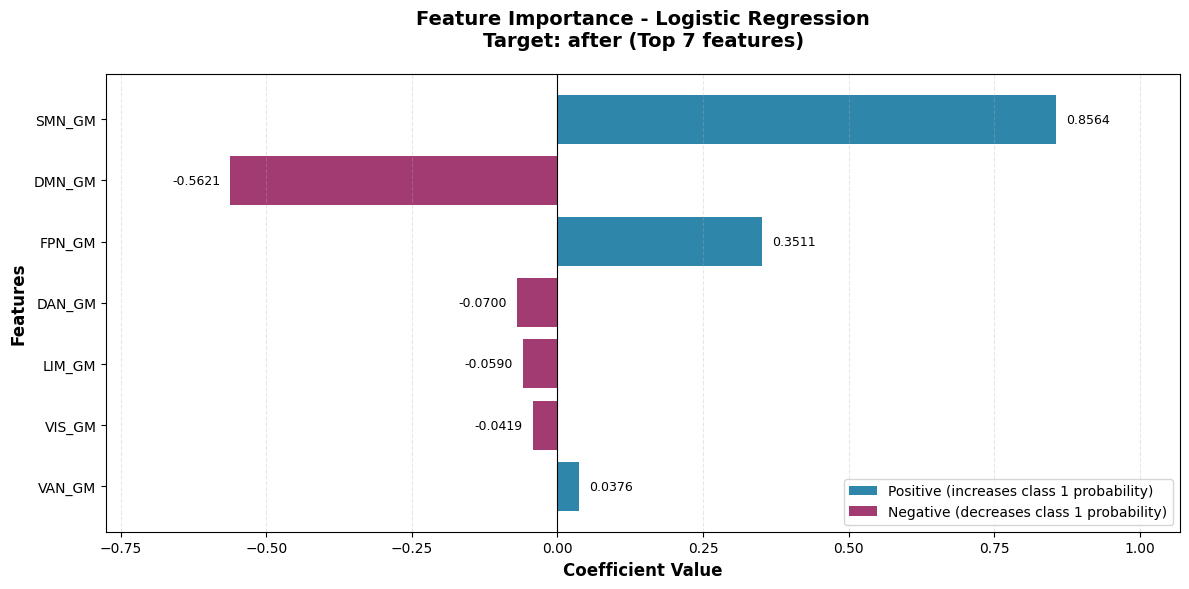


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.6075 (+/- 0.1099)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.000209  0.437500   0.250000     0.4  0.307692  0.472727       60   
1     2  0.129057  0.733333   0.500000     0.5  0.500000  0.772727       61   
2     3  0.024539  0.600000   0.333333     0.5  0.400000  0.409091       61   
3     4  0.011904  0.666667   0.400000     0.5  0.444444  0.636364       61   
4     5  0.034746  0.600000   0.333333     0.5  0.400000  0.636364       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:
# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined/T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features=10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: only_Q_outputs/combined/T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 6
Columns: ['subject_code', 'after', 'cingulate', 'frontal', 'parietal', 'temporal']

Target distribution (after):
  after = 0.0: 55 subjects (72.4%)
  after = 1.0: 21 subjects (27.6%)

Preparing features and target...
Feature columns (4): ['cingulate', 'frontal', 'parietal', 'temporal']

Valid subjects (after removing missing): 76
Removed 0 subjects with missing values
Target classes: [np.float64(0.0), np.float64(1.0)]

Standardizing features...
Features standardized: (76, 4)

LOGISTIC REGRESSION: Binary Classification with SMOTE Upsampling
Target: after
Features: 4 columns
Cross-validation: 5-fold stratified
Upsampling: Enabled (SMOTE)

--- Fold 1/5 ---
  Training data before upsampling: 60 samples
  Training data after upsampling: 88 samples
  Class distribution after upsampling: {np.float64(0.0): np.int64(44), np.float64(1.0): np.int64(44)

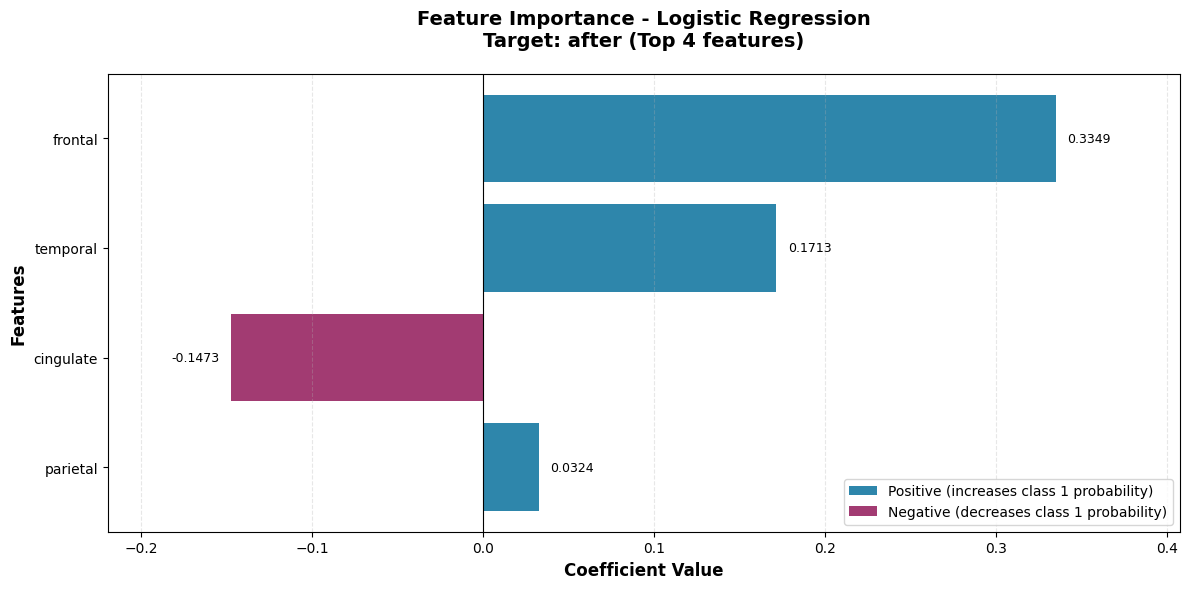


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.4750 (+/- 0.0804)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.013889  0.375000   0.222222    0.40  0.285714  0.327273       60   
1     2  0.000128  0.466667   0.250000    0.50  0.333333  0.500000       61   
2     3  0.018851  0.466667   0.250000    0.50  0.333333  0.409091       61   
3     4  0.053851  0.466667   0.166667    0.25  0.200000  0.386364       61   
4     5  0.011196  0.600000   0.250000    0.25  0.250000  0.340909       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:
# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined/T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features=10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: only_Q_outputs/combined/T1_lobes_lr_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 10
Columns: ['subject_code', 'after', 'cingulate_lh', 'cingulate_rh', 'frontal_lh', 'frontal_rh', 'parietal_lh', 'parietal_rh', 'temporal_lh', 'temporal_rh']

Target distribution (after):
  after = 0.0: 55 subjects (72.4%)
  after = 1.0: 21 subjects (27.6%)

Preparing features and target...
Feature columns (8): ['cingulate_lh', 'cingulate_rh', 'frontal_lh', 'frontal_rh', 'parietal_lh', 'parietal_rh', 'temporal_lh', 'temporal_rh']

Valid subjects (after removing missing): 76
Removed 0 subjects with missing values
Target classes: [np.float64(0.0), np.float64(1.0)]

Standardizing features...
Features standardized: (76, 8)

LOGISTIC REGRESSION: Binary Classification with SMOTE Upsampling
Target: after
Features: 8 columns
Cross-validation: 5-fold stratified
Upsampling: Enabled (SMOTE)

--- Fold 1/5 ---
  Training data before upsampling: 60 samples
  Training 

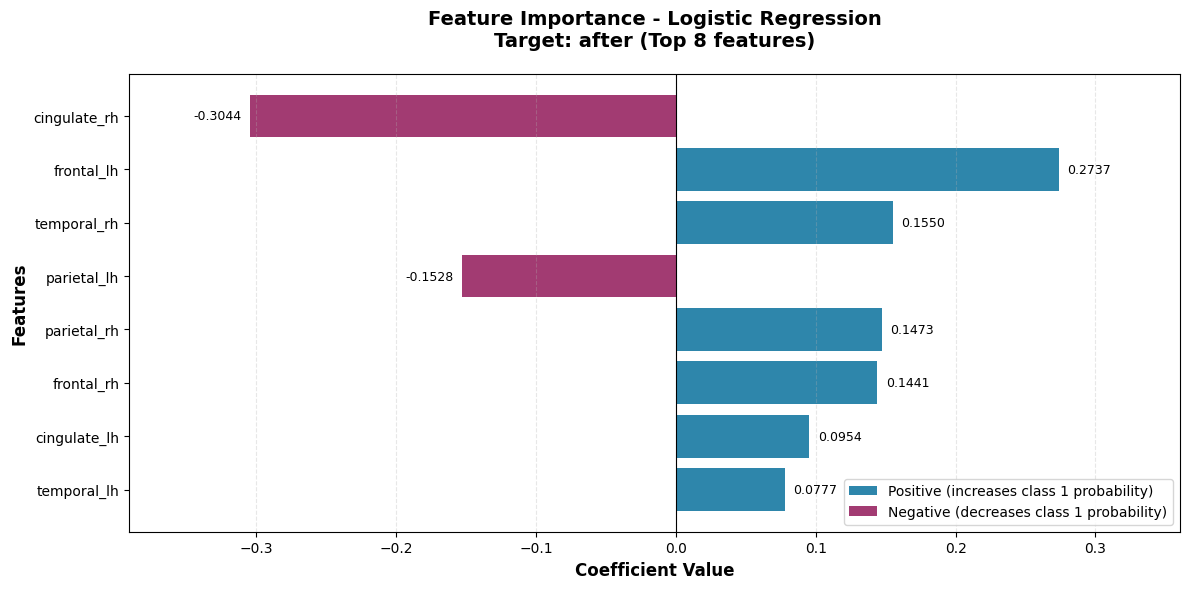


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.4458 (+/- 0.0713)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.010200  0.562500   0.333333    0.40  0.363636  0.454545       60   
1     2  0.002119  0.400000   0.142857    0.25  0.181818  0.454545       61   
2     3  0.078319  0.400000   0.142857    0.25  0.181818  0.386364       61   
3     4  0.084454  0.400000   0.142857    0.25  0.181818  0.318182       61   
4     5  0.103988  0.466667   0.166667    0.25  0.200000  0.272727       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:
# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined/T1_lobes_lr_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features=10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


In [ ]:
import pandas as pd
import re

# ----------------  
# Configuration
# ----------------
# Path to ttest file
ttest_file_path = r"ttest_longitude.xlsx"

# Sheet name (first sheet = index 0)
sheet_name = 0  # Change to sheet name if needed, or use 0 for first sheet

# Column name candidates for Parameter, Yeo, and Hemisphere columns
PARAMETER_COL_CANDIDATES = ["Parameter", "parameter", "STRUCT_NAME", "StructName"]
YEO_COL_CANDIDATES = ["Yeo", "YEO", "yeo", "Yeo_Network", "Network"]
HEMISPHERE_COL_CANDIDATES = ["Hemisphere", "hemisphere", "hemishpere", "Hemi", "hemi"]

# Specify which networks you want to filter
desired_networks = ["Frontoparietal", "Default Mode","Somatomotor"]  # CHANGE THIS to your desired networks
# Examples: ["DMN_GM", "DAN_GM", "FPN_GM", "LIM_GM", "SMN_GM", "VAN_GM", "VIS_GM"]

# ----------------  
# Helper function to find column names (case-insensitive)
# ----------------
def pick_column(df, candidates):
    """Return the first matching column name in df (case-insensitive), else None."""
    cols_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in cols_map:
            return cols_map[c.lower()]
    # try partial matches
    for c in candidates:
        for k, v in cols_map.items():
            if c.lower() in k:
                return v
    return None

# ----------------  
# Load ttest file
# ----------------
print(f"Loading ttest file: {ttest_file_path}")
print(f"Sheet: {sheet_name} (first sheet)")

df = pd.read_excel(ttest_file_path, sheet_name=sheet_name)

print(f"\nLoaded {len(df)} rows")
print(f"Columns: {list(df.columns)}")

# ----------------  
# Find Parameter, Yeo, and Hemisphere columns
# ----------------
param_col = pick_column(df, PARAMETER_COL_CANDIDATES)
yeo_col = pick_column(df, YEO_COL_CANDIDATES)
hemisphere_col = pick_column(df, HEMISPHERE_COL_CANDIDATES)

if not param_col:
    print(f"\nError: Could not find Parameter column.")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError("Parameter column not found")

if not yeo_col:
    print(f"\nError: Could not find Yeo/Network column.")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError("Yeo column not found")

if not hemisphere_col:
    print(f"\nError: Could not find Hemisphere column.")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError("Hemisphere column not found")

print(f"\nFound columns:")
print(f"  Parameter column: '{param_col}'")
print(f"  Yeo/Network column: '{yeo_col}'")
print(f"  Hemisphere column: '{hemisphere_col}'")

# ----------------  
# Filter by desired networks
# ----------------
print(f"\n{'='*70}")
print(f"Filtering for networks: {desired_networks}")
print(f"{'='*70}")

# Convert to string and check for matches (case-insensitive, partial match)
df[yeo_col] = df[yeo_col].astype(str)
df[param_col] = df[param_col].astype(str)

# Filter rows where Yeo column matches any of the desired networks
filtered_df = df[df[yeo_col].isin(desired_networks)].copy()

if len(filtered_df) == 0:
    print(f"\nWarning: No parameters found for networks: {desired_networks}")
    print(f"\nAvailable networks in file:")
    unique_networks = df[yeo_col].unique()
    for net in sorted(unique_networks):
        count = len(df[df[yeo_col] == net])
        print(f"  {net}: {count} parameters")
else:
    print(f"\nFound {len(filtered_df)} parameters in specified networks")

# ----------------  
# Use hemisphere column directly from the file
# ----------------
# The hemisphere information is already in the file
# Just rename for consistency and clean up
if hemisphere_col != 'Hemisphere':
    filtered_df = filtered_df.rename(columns={hemisphere_col: 'Hemisphere'})
# Convert to string and clean up
filtered_df['Hemisphere'] = filtered_df['Hemisphere'].astype(str).str.strip()

# ----------------  
# Display results
# ----------------
print(f"\n{'='*70}")
print(f"PARAMETERS IN SPECIFIED NETWORKS")
print(f"{'='*70}")

if len(filtered_df) > 0:
    # Group by network for better organization
    for network in desired_networks:
        network_params = filtered_df[filtered_df[yeo_col] == network]
        if len(network_params) > 0:
            print(f"\nNetwork: {network} ({len(network_params)} parameters)")
            print("-" * 70)
            
            for idx, row in network_params.iterrows():
                param = row[param_col]
                hemi = row['Hemisphere']
                print(f"  {param:<50} | Hemisphere: {hemi}")
        else:
            print(f"\nNetwork: {network} - No parameters found")
    
    # Summary by hemisphere
    print(f"\n{'='*70}")
    print("SUMMARY BY HEMISPHERE")
    print(f"{'='*70}")
    hemi_counts = filtered_df['Hemisphere'].value_counts()
    for hemi, count in hemi_counts.items():
        print(f"  {hemi.capitalize()}: {count} parameters")
    
    # Summary by network
    print(f"\n{'='*70}")
    print("SUMMARY BY NETWORK")
    print(f"{'='*70}")
    network_counts = filtered_df[yeo_col].value_counts()
    for net, count in network_counts.items():
        print(f"  {net}: {count} parameters")
    
    # Create a formatted table
    print(f"\n{'='*70}")
    print("FORMATTED TABLE")
    print(f"{'='*70}")
    
    # Select relevant columns for display
    display_df = filtered_df[[param_col, yeo_col, 'Hemisphere']].copy()
    display_df = display_df.sort_values([yeo_col, 'Hemisphere', param_col]).reset_index(drop=True)
    
    print(display_df.to_string(index=False))
    
    # Show all unique parameters (for easy copying)
    print(f"\n{'='*70}")
    print("ALL PARAMETER NAMES (for easy copying):")
    print(f"{'='*70}")
    all_params = sorted(filtered_df[param_col].unique())
    for i, param in enumerate(all_params, 1):
        print(f"{i}. {param}")
        
else:
    print(f"\nNo parameters found. Available networks in file:")
    unique_networks = df[yeo_col].unique()
    for net in sorted(unique_networks):
        count = len(df[df[yeo_col] == net])
        print(f"  {net}: {count} parameters")

Loading ttest file: ttest_longitude.xlsx
Sheet: 0 (first sheet)

Loaded 68 rows
Columns: ['Parameter', 'Lobe', 'Yeo', 'Hemisphere', 'Mean_ses1', 'Mean_ses2', 'delta', 't', 'p', 'df', 'Cohen_d', 'p_corrected', 'Significant_FDR']

Found columns:
  Parameter column: 'Parameter'
  Yeo/Network column: 'Yeo'
  Hemisphere column: 'Hemisphere'

Filtering for networks: ['Frontoparietal', 'Default Mode', 'Somatomotor']

Found 34 parameters in specified networks

PARAMETERS IN SPECIFIED NETWORKS

Network: Frontoparietal (12 parameters)
----------------------------------------------------------------------
  bankssts                                           | Hemisphere: lh
  bankssts                                           | Hemisphere: rh
  caudalmiddlefrontal                                | Hemisphere: lh
  caudalmiddlefrontal                                | Hemisphere: rh
  fusiform                                           | Hemisphere: lh
  fusiform                                      

In [ ]:
# ----------------  
# Generate tuples list from filtered_df
# ----------------

# Sheet name to use (modify this based on your actual sheet name)
SHEET_NAME = "cortical_vol_lr"  # CHANGE THIS to your actual sheet name

# Generate tuples: (parameter_hemisphere, sheet_name)
tuples_list = []

for idx, row in filtered_df.iterrows():
    param = row[param_col]
    hemi = row['Hemisphere'].lower()  # Ensure lowercase (lh/rh)
    param_hemisphere = f"{param}_{hemi}"
    tuples_list.append((param_hemisphere, SHEET_NAME))

print(f"Generated {len(tuples_list)} tuples:")
print("\nAll tuples:")
for i, tup in enumerate(tuples_list, 1):
    print(f"  {i}. {tup}")

# Display as a Python list you can copy
print(f"\n{'='*70}")
print("TUPLES LIST (Python format - copy this):")
print(f"{'='*70}")
print("tuples_list = [")
for tup in tuples_list:
    print(f"    {tup},")
print("]")

# Also print just the list for easy copying
print(f"\n{'='*70}")
print("Just the list:")
print(f"{'='*70}")
print(tuples_list)

Generated 34 tuples:

All tuples:
  1. ('bankssts_lh', 'cortical_vol_lr')
  2. ('bankssts_rh', 'cortical_vol_lr')
  3. ('caudalanteriorcingulate_lh', 'cortical_vol_lr')
  4. ('caudalanteriorcingulate_rh', 'cortical_vol_lr')
  5. ('caudalmiddlefrontal_lh', 'cortical_vol_lr')
  6. ('caudalmiddlefrontal_rh', 'cortical_vol_lr')
  7. ('fusiform_lh', 'cortical_vol_lr')
  8. ('fusiform_rh', 'cortical_vol_lr')
  9. ('inferiortemporal_lh', 'cortical_vol_lr')
  10. ('inferiortemporal_rh', 'cortical_vol_lr')
  11. ('isthmuscingulate_lh', 'cortical_vol_lr')
  12. ('isthmuscingulate_rh', 'cortical_vol_lr')
  13. ('middletemporal_lh', 'cortical_vol_lr')
  14. ('middletemporal_rh', 'cortical_vol_lr')
  15. ('paracentral_lh', 'cortical_vol_lr')
  16. ('paracentral_rh', 'cortical_vol_lr')
  17. ('postcentral_lh', 'cortical_vol_lr')
  18. ('postcentral_rh', 'cortical_vol_lr')
  19. ('posteriorcingulate_lh', 'cortical_vol_lr')
  20. ('posteriorcingulate_rh', 'cortical_vol_lr')
  21. ('precentral_lh', 'co

In [ ]:
# Configuration
columns_to_extract = [('bankssts_lh', 'cortical_vol_lr'), 
('bankssts_rh', 'cortical_vol_lr'),
 ('caudalanteriorcingulate_lh', 'cortical_vol_lr'),
  ('caudalanteriorcingulate_rh', 'cortical_vol_lr'),
   ('caudalmiddlefrontal_lh', 'cortical_vol_lr'), 
   ('caudalmiddlefrontal_rh', 'cortical_vol_lr'), 
   ('fusiform_lh', 'cortical_vol_lr'), 
   ('fusiform_rh', 'cortical_vol_lr'), 
   ('inferiortemporal_lh', 'cortical_vol_lr'), 
   ('inferiortemporal_rh', 'cortical_vol_lr'), 
   ('isthmuscingulate_lh', 'cortical_vol_lr'), 
   ('isthmuscingulate_rh', 'cortical_vol_lr'), 
   ('middletemporal_lh', 'cortical_vol_lr'), 
   ('middletemporal_rh', 'cortical_vol_lr'), 
   ('paracentral_lh', 'cortical_vol_lr'), 
   ('paracentral_rh', 'cortical_vol_lr'), 
   ('postcentral_lh', 'cortical_vol_lr'), 
   ('postcentral_rh', 'cortical_vol_lr'),
    ('posteriorcingulate_lh', 'cortical_vol_lr'), 
    ('posteriorcingulate_rh', 'cortical_vol_lr'), 
    ('precentral_lh', 'cortical_vol_lr'),
     ('precentral_rh', 'cortical_vol_lr'), 
     ('precuneus_lh', 'cortical_vol_lr'), 
     ('precuneus_rh', 'cortical_vol_lr'), 
     ('rostralanteriorcingulate_lh', 'cortical_vol_lr'),
      ('rostralanteriorcingulate_rh', 'cortical_vol_lr'),
       ('rostralmiddlefrontal_lh', 'cortical_vol_lr'), 
       ('rostralmiddlefrontal_rh', 'cortical_vol_lr'),
        ('superiorfrontal_lh', 'cortical_vol_lr'),
         ('superiorfrontal_rh', 'cortical_vol_lr'), 
         ('superiortemporal_lh', 'cortical_vol_lr'), 
         ('superiortemporal_rh', 'cortical_vol_lr'), 
         ('transversetemporal_lh', 'cortical_vol_lr'),
         ('transversetemporal_rh', 'cortical_vol_lr'),
    ("etiv", "global_parameters")
]

output_filename = "T1_networks_parcels_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv"

# Call the function
df = extract_and_normalize_t1_data(
    columns_to_extract=columns_to_extract,
    output_filename=output_filename
)

Loading transitions file: only_Q_outputs/combined/timepoints_file_inverted_2_with_meta_and_transitions.csv
Transitions subjects: 109

Processing 35 column(s) to extract...
Columns grouped into 2 sheet(s)

Processing sheet: cortical_vol_lr
Columns requested: ['bankssts_lh', 'bankssts_rh', 'caudalanteriorcingulate_lh', 'caudalanteriorcingulate_rh', 'caudalmiddlefrontal_lh', 'caudalmiddlefrontal_rh', 'fusiform_lh', 'fusiform_rh', 'inferiortemporal_lh', 'inferiortemporal_rh', 'isthmuscingulate_lh', 'isthmuscingulate_rh', 'middletemporal_lh', 'middletemporal_rh', 'paracentral_lh', 'paracentral_rh', 'postcentral_lh', 'postcentral_rh', 'posteriorcingulate_lh', 'posteriorcingulate_rh', 'precentral_lh', 'precentral_rh', 'precuneus_lh', 'precuneus_rh', 'rostralanteriorcingulate_lh', 'rostralanteriorcingulate_rh', 'rostralmiddlefrontal_lh', 'rostralmiddlefrontal_rh', 'superiorfrontal_lh', 'superiorfrontal_rh', 'superiortemporal_lh', 'superiortemporal_rh', 'transversetemporal_lh', 'transversetempo

Loading file: only_Q_outputs/combined\T1_networks_parcels_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 36
Columns: ['subject_code', 'after', 'bankssts_lh', 'bankssts_rh', 'caudalanteriorcingulate_lh', 'caudalanteriorcingulate_rh', 'caudalmiddlefrontal_lh', 'caudalmiddlefrontal_rh', 'fusiform_lh', 'fusiform_rh', 'inferiortemporal_lh', 'inferiortemporal_rh', 'isthmuscingulate_lh', 'isthmuscingulate_rh', 'middletemporal_lh', 'middletemporal_rh', 'paracentral_lh', 'paracentral_rh', 'postcentral_lh', 'postcentral_rh', 'posteriorcingulate_lh', 'posteriorcingulate_rh', 'precentral_lh', 'precentral_rh', 'precuneus_lh', 'precuneus_rh', 'rostralanteriorcingulate_lh', 'rostralanteriorcingulate_rh', 'rostralmiddlefrontal_lh', 'rostralmiddlefrontal_rh', 'superiorfrontal_lh', 'superiorfrontal_rh', 'superiortemporal_lh', 'superiortemporal_rh', 'transversetemporal_lh', 'transversetemporal_rh']

Target distribution (after):
  after = 0.0: 55 subjects (72

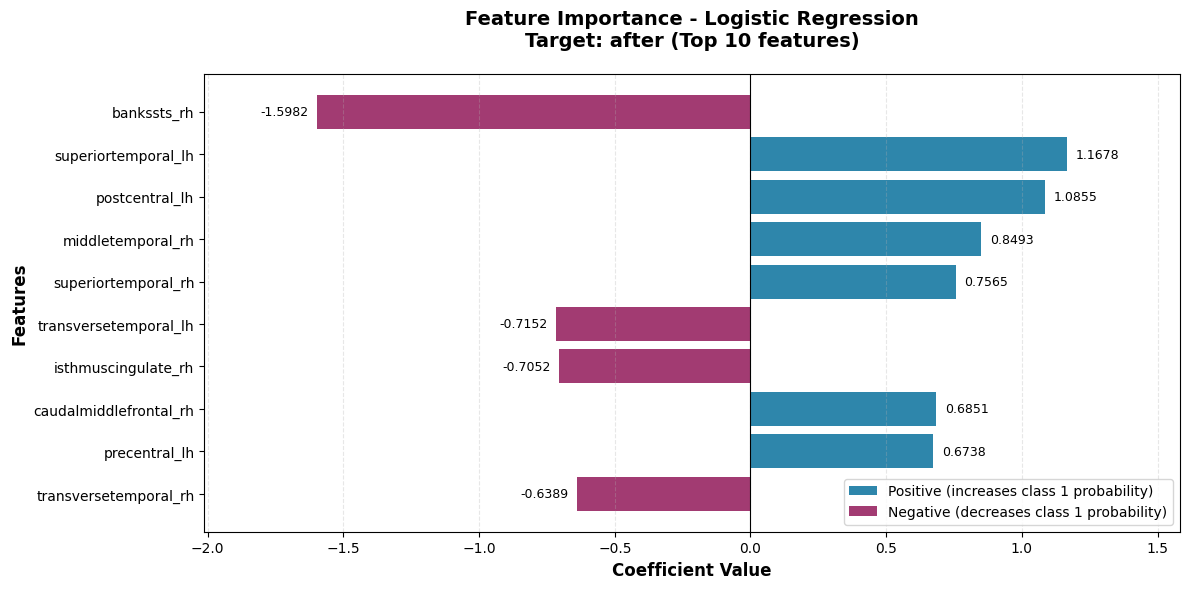


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.6558 (+/- 0.1036)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.358301  0.812500   0.666667    0.80  0.727273  0.854545       60   
1     2  0.028764  0.666667   0.400000    0.50  0.444444  0.636364       61   
2     3  0.017885  0.533333   0.285714    0.50  0.363636  0.659091       61   
3     4  0.043942  0.666667   0.333333    0.25  0.285714  0.659091       61   
4     5  0.000617  0.600000   0.000000    0.00  0.000000  0.681818       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:
# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined\T1_networks_parcels_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features=10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])
